## Set Up

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
cd /content/drive/MyDrive/ForecastFrontiers/Online Retail

/content/drive/MyDrive/ForecastFrontiers/Online Retail


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import math
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
from scipy.signal import welch
from statsmodels.tsa.stattools import adfuller
import itertools
import warnings
warnings.filterwarnings("ignore")

# from prophet import Prophet
# from prophet.diagnostics import cross_validation
# from prophet.diagnostics import performance_metrics
# from prophet.plot import add_changepoints_to_plot

## Load Data

In [4]:
# Upload data to My Drive
file_path = "online_retail_II.xlsx"
# file_path = "/Users/daidai/Desktop/IEOR4578 Forecasting/online_retail_II.xlsx"
# file_path = "/content/drive/My Drive/IEOR_Forecasting_Project/online_retail_II.xlsx"
# There are two data in the excel
df_2009_2010 = pd.read_excel(file_path, sheet_name="Year 2009-2010")
df_2010_2011 = pd.read_excel(file_path, sheet_name="Year 2010-2011")

In [ ]:
# df_2009_2010.head(10)

In [ ]:
# df_2010_2011.head(10)

## EDA

### Combine Data

In [5]:
df = pd.concat([df_2009_2010, df_2010_2011], axis=0)
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])
df = df.sort_values(by="InvoiceDate")
df.reset_index(drop=True, inplace=True)

In [ ]:
df.head(10)

In [ ]:
df.tail(10)

### Overview of Data

In [ ]:
# print(df.info())

# Display descriptive statistics
# print(df.describe(include='all'))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype         
---  ------       --------------    -----         
 0   Invoice      1067371 non-null  object        
 1   StockCode    1067371 non-null  object        
 2   Description  1062989 non-null  object        
 3   Quantity     1067371 non-null  int64         
 4   InvoiceDate  1067371 non-null  datetime64[ns]
 5   Price        1067371 non-null  float64       
 6   Customer ID  824364 non-null   float64       
 7   Country      1067371 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 65.1+ MB
None


### Cleaning Value

In [ ]:
# df.isna().sum()

Invoice             0
StockCode           0
Description      4382
Quantity            0
InvoiceDate         0
Price               0
Customer ID    243007
Country             0
dtype: int64

In [6]:
df.dropna(subset=['Description'], inplace=True)
# df = df[~df["Description"].str.contains(r'\?', regex=True)]
df = df[~df['Description'].str.contains(r'[\?\*\!@#\$%\^\&]', na=False)]
df = df[~df['Description'].str.lower().isin(['mixed up', 'lost'])]
df.drop('Customer ID', axis=1, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1057269 entries, 0 to 1067370
Data columns (total 7 columns):
 #   Column       Non-Null Count    Dtype         
---  ------       --------------    -----         
 0   Invoice      1057269 non-null  object        
 1   StockCode    1057269 non-null  object        
 2   Description  1057269 non-null  object        
 3   Quantity     1057269 non-null  int64         
 4   InvoiceDate  1057269 non-null  datetime64[ns]
 5   Price        1057269 non-null  float64       
 6   Country      1057269 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(4)
memory usage: 64.5+ MB


In [7]:
# negative values in the column of Quantity
df.sort_values(by = "Price", ascending  = False).head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Country
748142,C556445,M,Manual,-1,2011-06-10 15:31:00,38970.00,United Kingdom
241827,512771,M,Manual,1,2010-06-17 16:53:00,25111.09,United Kingdom
241826,C512770,M,Manual,-1,2010-06-17 16:52:00,25111.09,United Kingdom
320581,C520667,BANK CHARGES,Bank Charges,-1,2010-08-27 13:42:00,18910.69,United Kingdom
1050063,C580605,AMAZONFEE,AMAZON FEE,-1,2011-12-05 11:36:00,17836.46,United Kingdom


In [8]:
# negative values in the column of Price
df.sort_values(by = "Price", ascending  = True).head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Country
179403,A506401,B,Adjust bad debt,1,2010-04-29 13:36:00,-53594.36,United Kingdom
276274,A516228,B,Adjust bad debt,1,2010-07-19 11:24:00,-44031.79,United Kingdom
403472,A528059,B,Adjust bad debt,1,2010-10-20 12:04:00,-38925.87,United Kingdom
825444,A563186,B,Adjust bad debt,1,2011-08-12 14:51:00,-11062.06,United Kingdom
825445,A563187,B,Adjust bad debt,1,2011-08-12 14:52:00,-11062.06,United Kingdom


In [9]:
df = df[df["Quantity"] > 0]
df = df[df["Price"] > 0]
df = df[~df["Invoice"].str.contains("C", na=False)]
df['Sales'] = df['Quantity'] * df['Price']
df.head(5)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Country,Sales
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,United Kingdom,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,United Kingdom,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,United Kingdom,81.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,United Kingdom,100.8
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,United Kingdom,30.0


In [10]:
df[['Quantity','Price','Sales']].describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,1036161.0,10.957604,126.474819,1.000,1.00,3.00,10.00,80995.00
Price,1036161.0,4.082778,51.583981,0.001,1.25,2.10,4.13,25111.09
Sales,1036161.0,20.158621,203.633383,0.001,3.90,9.96,17.70,168469.60


In [11]:
df['InvoiceDate']=pd.to_datetime(df['InvoiceDate'])

### Visualization

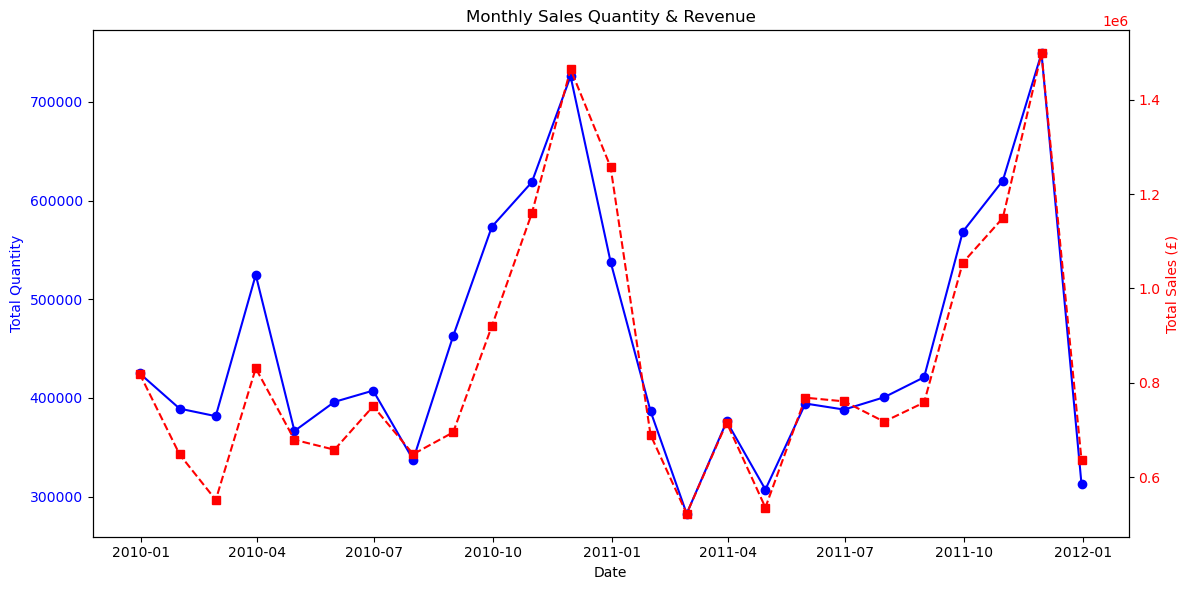

In [ ]:
# monthly_quantity = df.resample('M', on='InvoiceDate')['Quantity'].sum()
# monthly_sales = df.resample('M', on='InvoiceDate')['Sales'].sum()

# fig, ax1 = plt.subplots(figsize=(12,6))

# ax1.plot(monthly_quantity, marker='o', linestyle='-', color='b', label='Total Quantity')
# ax1.set_xlabel('Date')
# ax1.set_ylabel('Total Quantity', color='b')
# ax1.tick_params(axis='y', labelcolor='b')

# ax2 = ax1.twinx()
# ax2.plot(monthly_sales, marker='s', linestyle='--', color='r', label='Total Sales (£)')
# ax2.set_ylabel('Total Sales (£)', color='r')
# ax2.tick_params(axis='y', labelcolor='r')

# plt.title('Monthly Sales Quantity & Revenue')
# fig.tight_layout()
# plt.show()

<Figure size 1200x600 with 0 Axes>

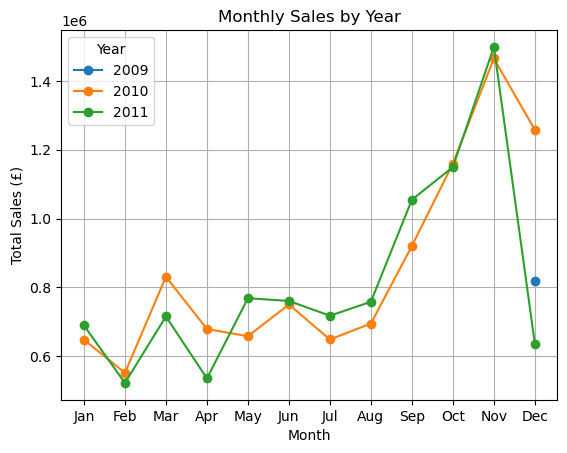

In [ ]:
# df['Year'] = df['InvoiceDate'].dt.year
# df['Month'] = df['InvoiceDate'].dt.month

# monthly_sales_by_year = df.groupby(['Year', 'Month'])['Sales'].sum().unstack(level=0)

# plt.figure(figsize=(12,6))
# monthly_sales_by_year.plot(marker='o', linestyle='-')
# plt.title('Monthly Sales by Year')
# plt.xlabel('Month')
# plt.ylabel('Total Sales (£)')
# plt.xticks(ticks=range(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
# plt.legend(title='Year')
# plt.grid(True)
# plt.show()

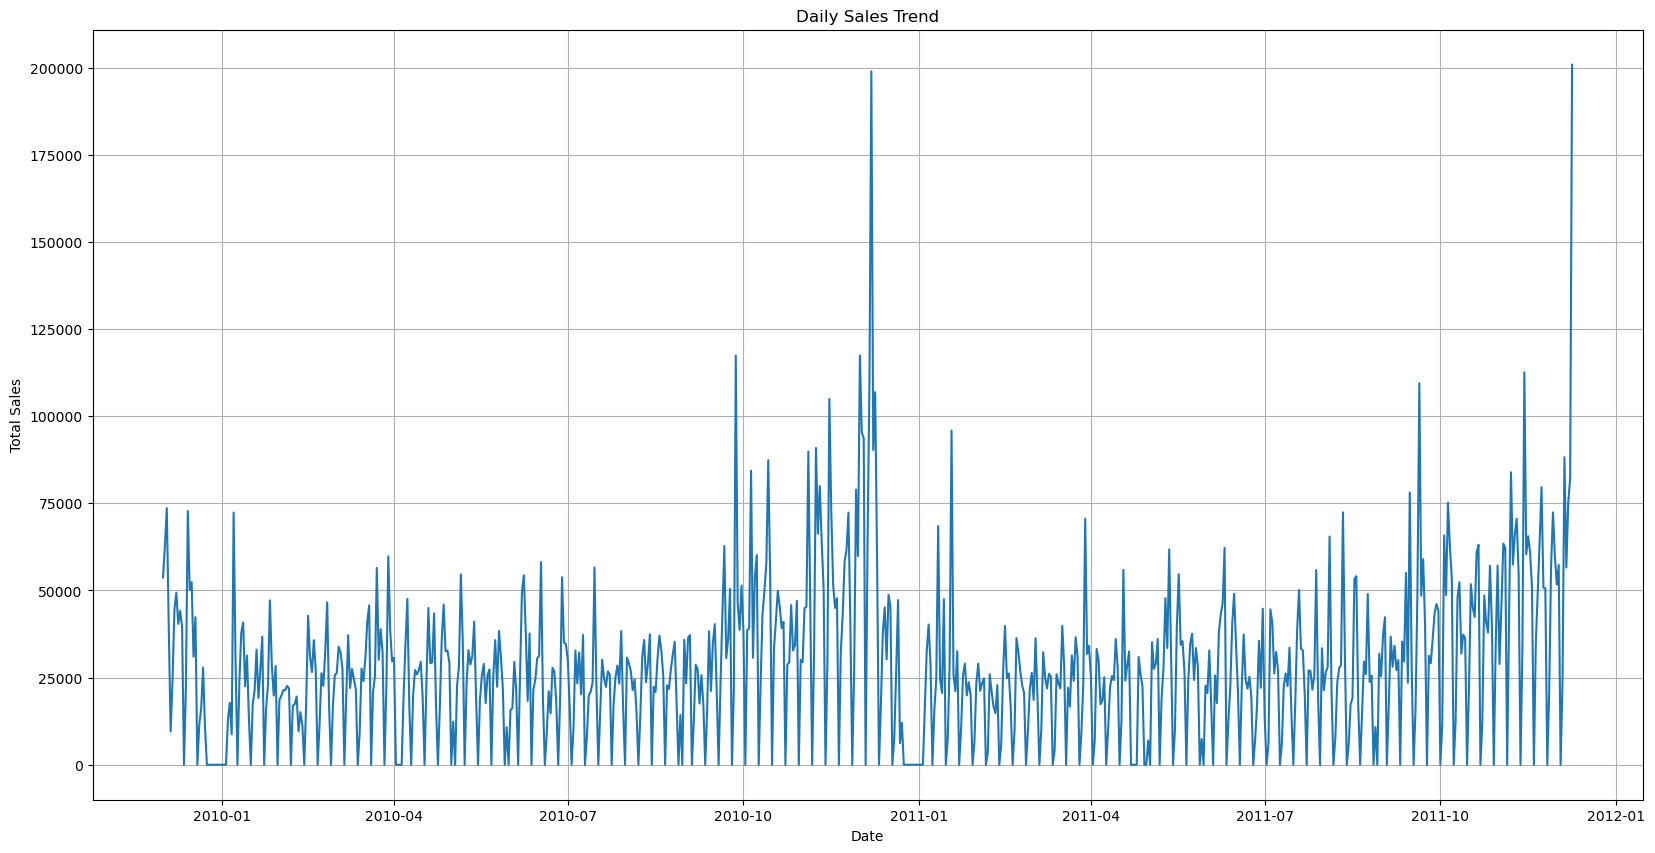

In [ ]:
# daily_sales = df.resample('D', on='InvoiceDate')['Sales'].sum()
# plt.figure(figsize=(20,10))
# plt.plot(daily_sales)
# plt.title('Daily Sales Trend')
# plt.xlabel('Date')
# plt.ylabel('Total Sales')
# plt.grid(True)
# plt.show()

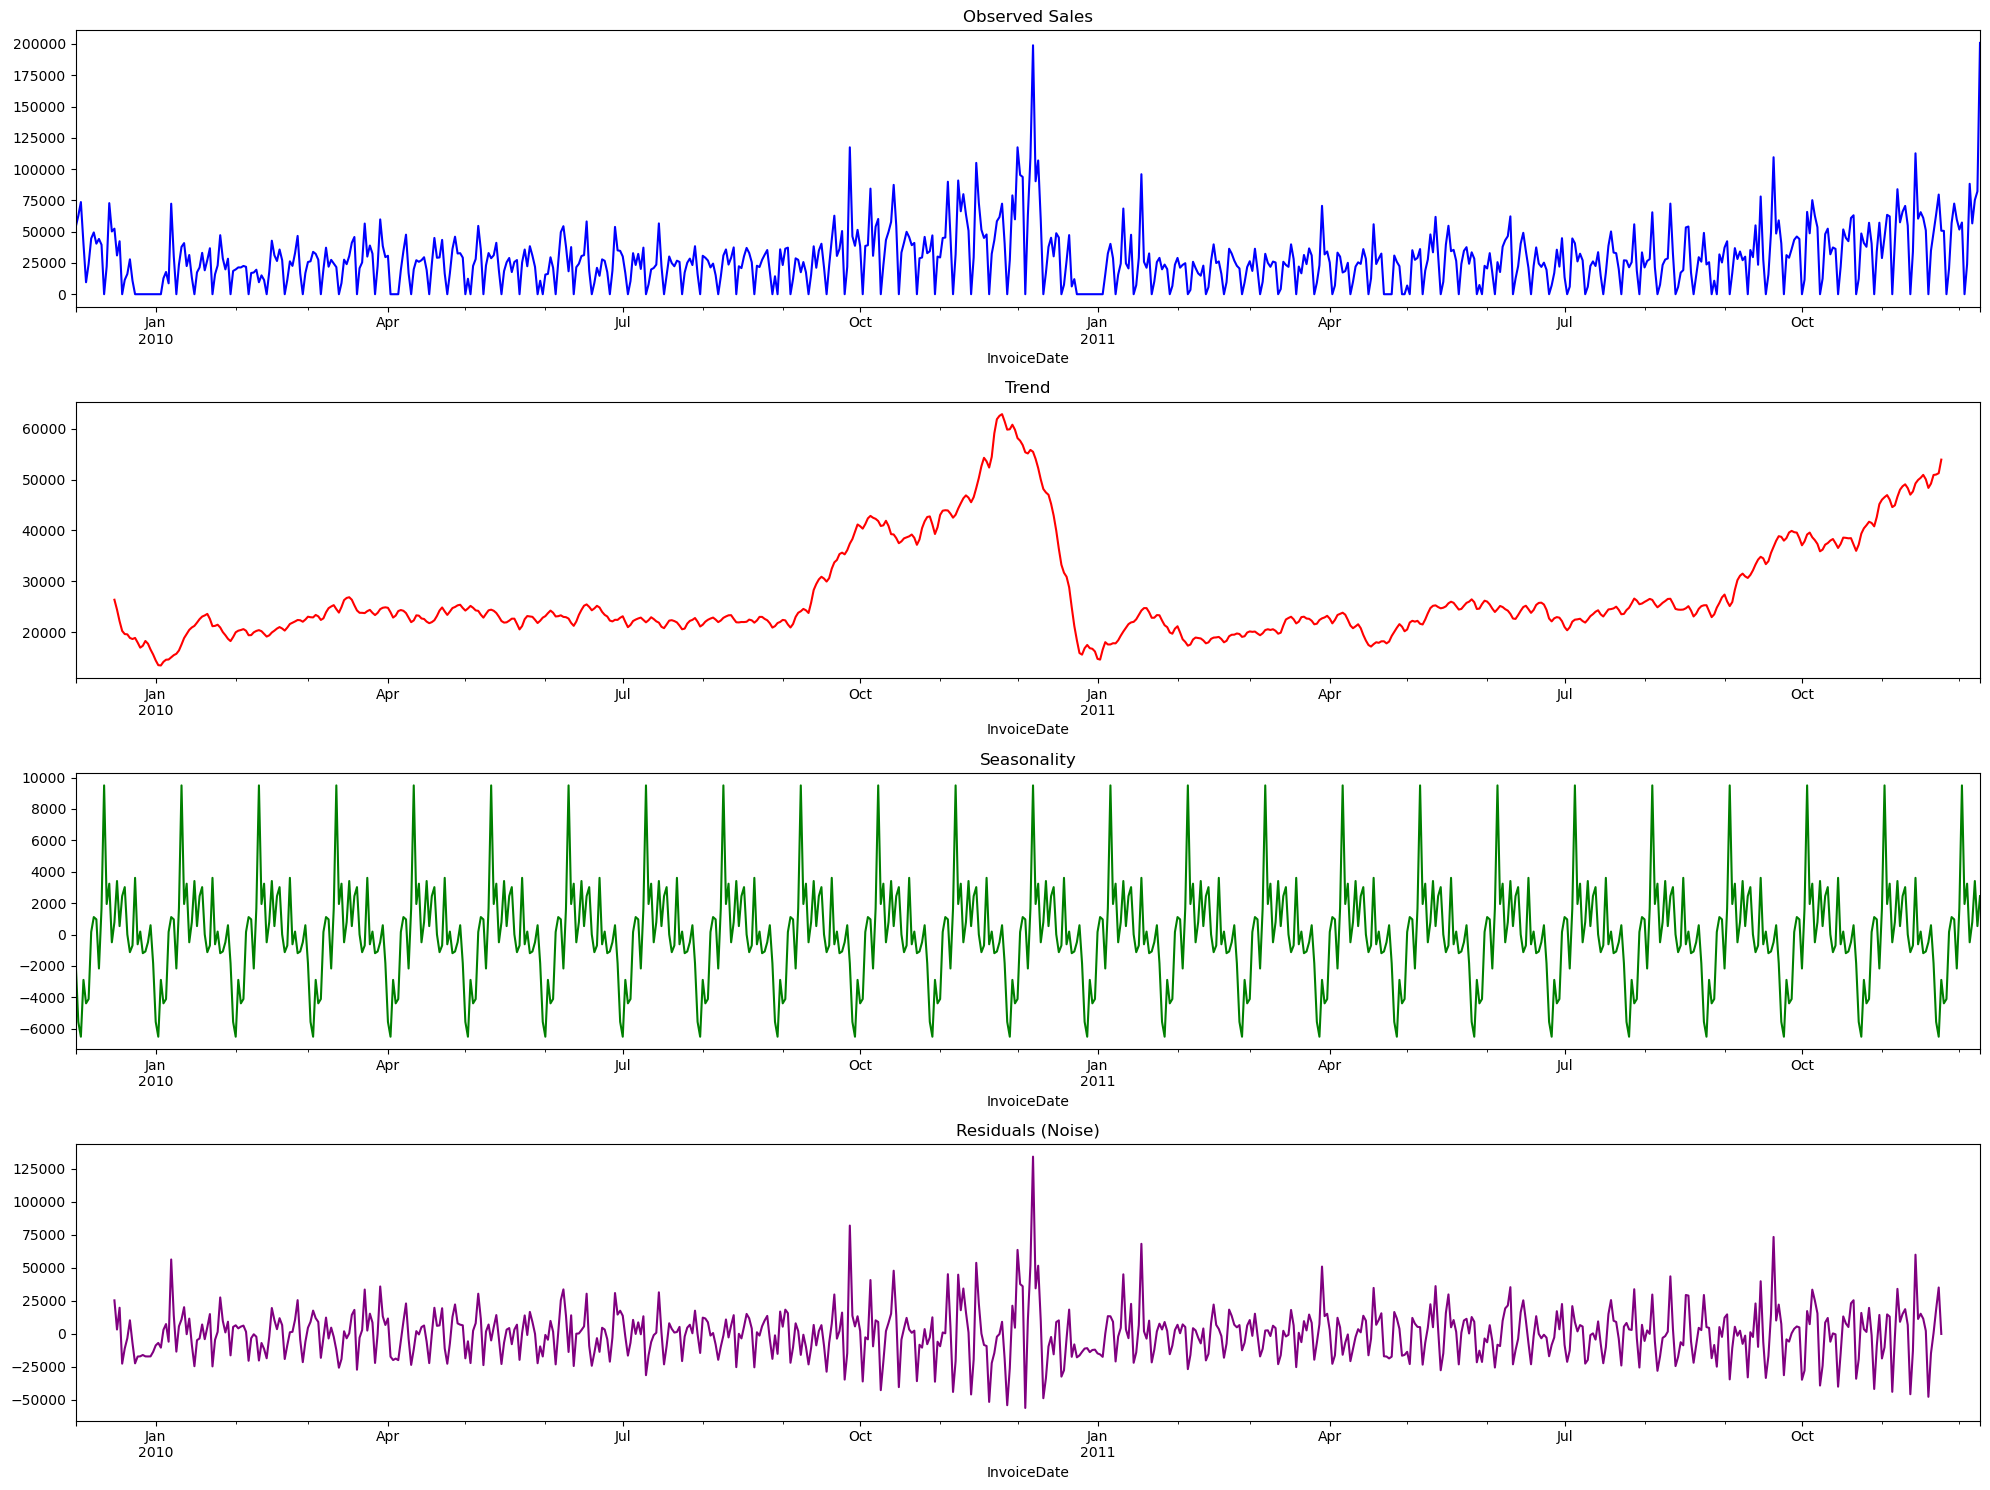

In [ ]:
# decomposed = seasonal_decompose(daily_sales, model='additive', period=30)

# fig, axes = plt.subplots(4, 1, figsize=(20, 15))
# decomposed.observed.plot(ax=axes[0], color='blue', title='Observed Sales')
# decomposed.trend.plot(ax=axes[1], color='red', title='Trend')
# decomposed.seasonal.plot(ax=axes[2], color='green', title='Seasonality')
# # Plot residual component (anomalies, noise)
# decomposed.resid.plot(ax=axes[3], color='purple', title='Residuals (Noise)')

# plt.tight_layout()
# plt.show()

- The sales data is highly volatile with frequent spikes. The trend shows a steady increase in sales over time, especially after mid-2010.
- There is a sharp drop in early 2011, followed by another increasing trend. This strong upward movement indicates that the time series is **not stationary** since there is a clear directionality over time.
- The recurring peaks suggest monthly or weekly cycles in sales.
- The residual component has some extreme spikes, especially aligning with sharp movements in the observed data. This suggests that certain external factors - anomalies (such as promotions, holidays, or anomalies) might be influencing sales.

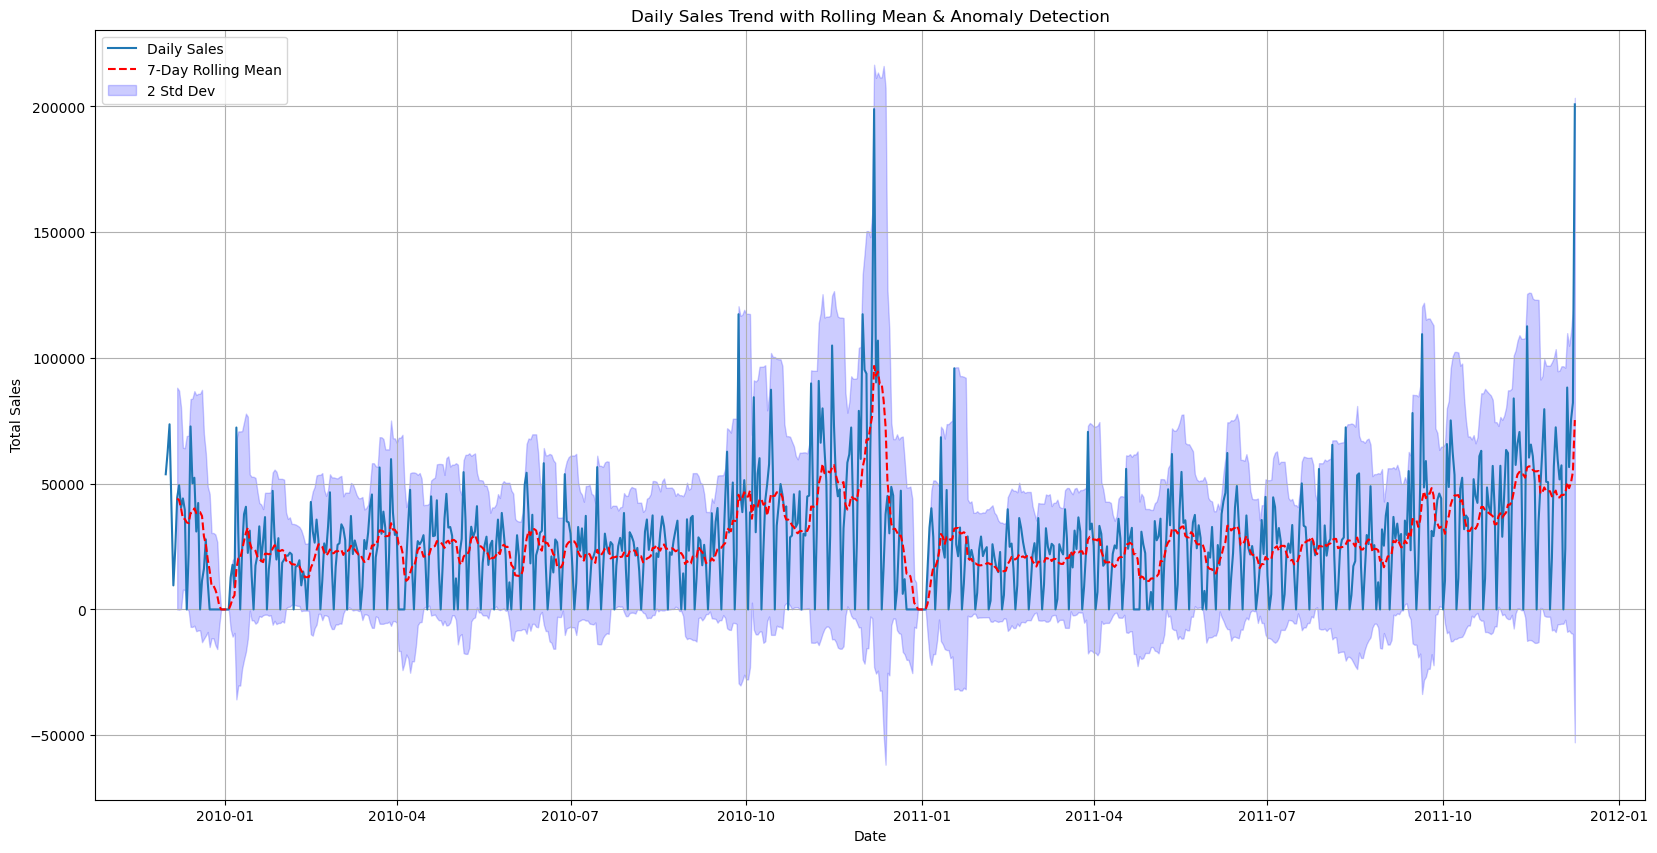

In [ ]:
# # Compute 7 days rolling mean and standard deviation
# rolling_mean = daily_sales.rolling(window=7).mean()
# rolling_std = daily_sales.rolling(window=7).std()

# plt.figure(figsize=(20,10))
# plt.plot(daily_sales, label='Daily Sales')
# plt.plot(rolling_mean, linestyle='dashed', color='red', label='7-Day Rolling Mean')
# plt.fill_between(daily_sales.index, rolling_mean - 2*rolling_std, rolling_mean + 2*rolling_std, color='b', alpha=0.2, label='2 Std Dev')

# plt.title('Daily Sales Trend with Rolling Mean & Anomaly Detection')
# plt.xlabel('Date')
# plt.ylabel('Total Sales')
# plt.legend()
# plt.grid(True)
# plt.show()

<Figure size 1200x600 with 0 Axes>

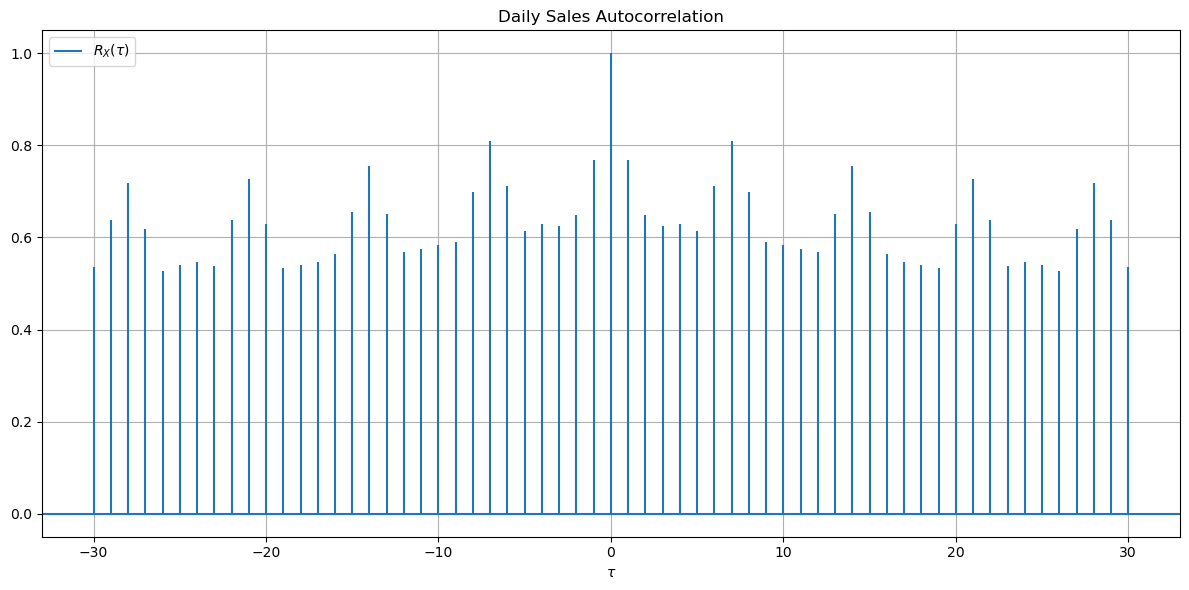

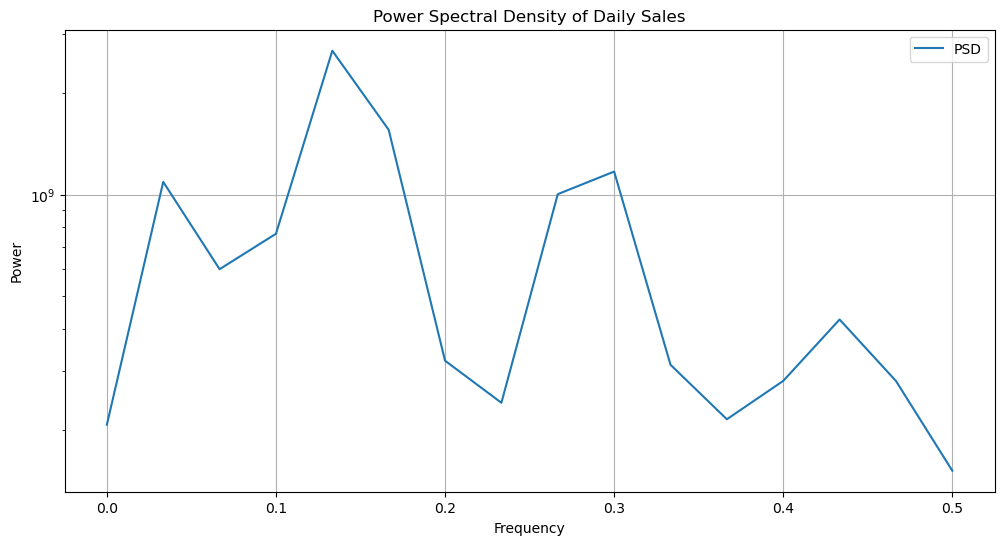

In [ ]:
# plt.figure(figsize=(12, 6))
# fig, ax = plt.subplots(figsize=(12, 6))
# ax.acorr(daily_sales, maxlags=30, usevlines=True, linestyle='solid')
# plt.xlabel(r'$\tau$')
# plt.legend([r'$R_X(\tau)$'], loc='upper left')
# plt.title('Daily Sales Autocorrelation')
# ax.grid(True, which='both')

# plt.tight_layout()
# plt.show()

# freq, psd = welch(daily_sales, nperseg=30)  # 30-day window


# plt.figure(figsize=(12, 6))
# plt.semilogy(freq, psd)
# plt.title("Power Spectral Density of Daily Sales")
# plt.xlabel("Frequency")
# plt.ylabel("Power")
# plt.grid(True)
# plt.legend(['PSD'])
# plt.show()

Peaks at low frequencies indicate strong long-term trends.
The presence of periodic peaks confirms seasonality in sales.

### Apply filter (Moving Average)

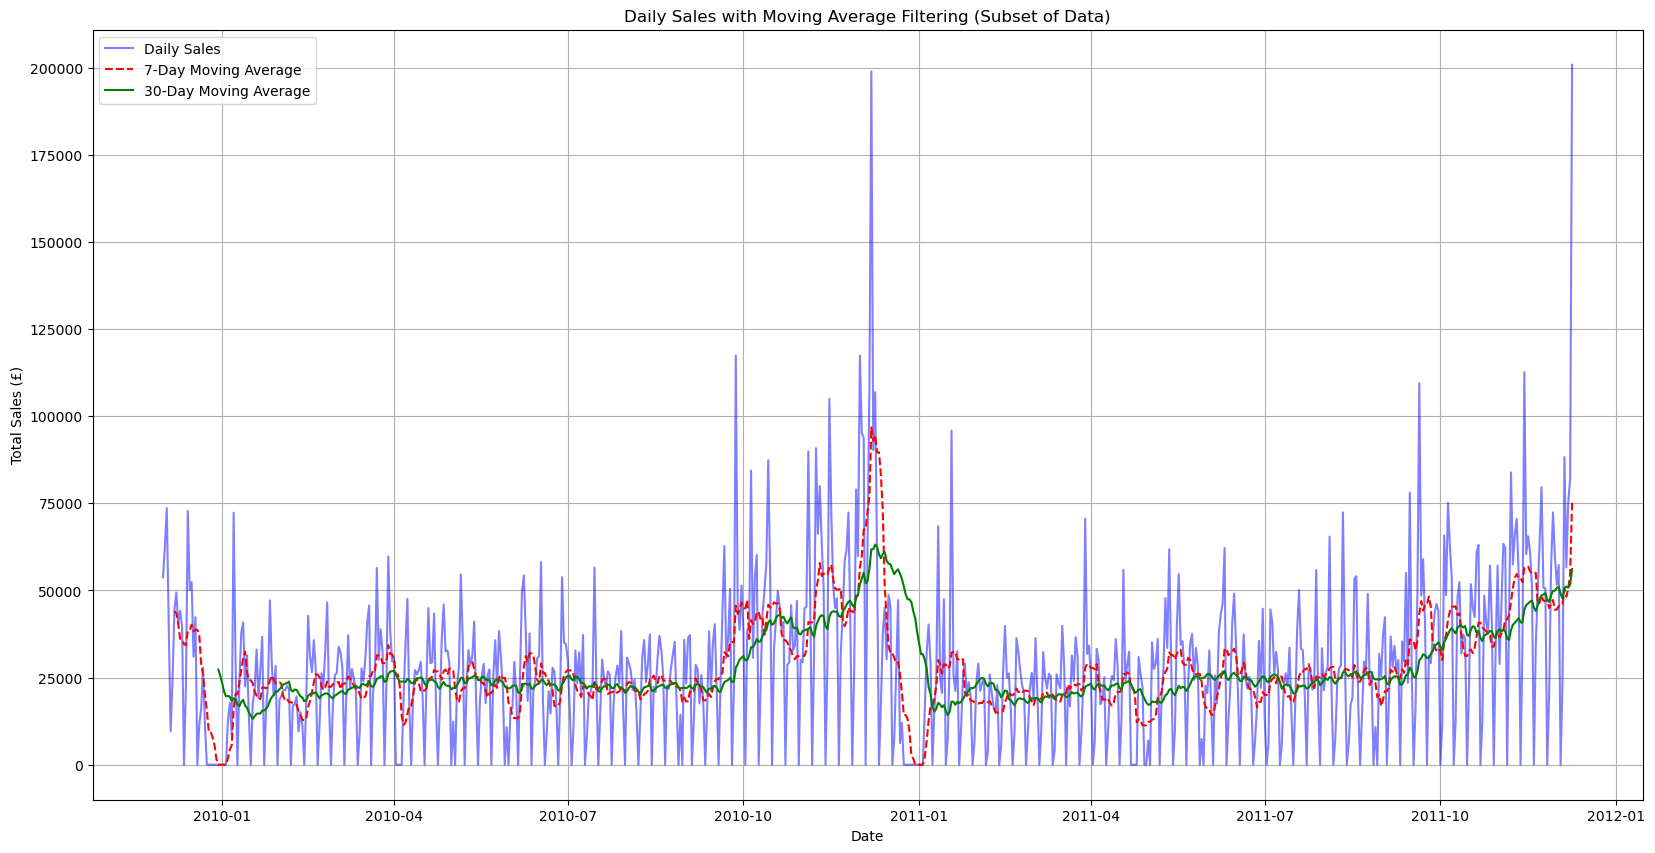

In [ ]:
# ma_30 = daily_sales.rolling(window=30).mean()

# plt.figure(figsize=(20,10))
# plt.plot(daily_sales, color='blue', alpha=0.5, label='Daily Sales')
# plt.plot(rolling_mean, color='red', linestyle='dashed', label='7-Day Moving Average')
# plt.plot(ma_30, color='green', linestyle='-', label='30-Day Moving Average')

# plt.title('Daily Sales with Moving Average Filtering (Subset of Data)')
# plt.xlabel('Date')
# plt.ylabel('Total Sales (£)')
# plt.legend()
# plt.grid(True)
# plt.show()

- Short-term variations (7-day MA) show weekly seasonality.
- Long-term trends (30-day MA) highlight seasonal cycles (likely tied to holidays and promotions).
- The sharp spikes and drops suggest external influences (e.g., promotions, holidays, or demand shocks).

### Stationarity Test

In [ ]:
# # Perform Augmented Dickey-Fuller (ADF) test on the daily sales data
# adf_result = adfuller(daily_sales)
# adf_statistic = adf_result[0]
# p_value = adf_result[1]
# critical_values = adf_result[4]

# adf_output = {
#     "ADF Statistic": adf_statistic,
#     "p-value": p_value,
#     "1% Critical Value": critical_values["1%"],
#     "5% Critical Value": critical_values["5%"],
#     "10% Critical Value": critical_values["10%"]
# }

# adf_output

{'ADF Statistic': -2.0107285068308305,
 'p-value': 0.28188892550049616,
 '1% Critical Value': -3.439490435810785,
 '5% Critical Value': -2.8655738086413374,
 '10% Critical Value': -2.568918067209286}

- p-value (0.28) is greater than 0.05 → Fail to reject the null hypothesis (H₀), meaning the series is non-stationary.
- ADF Statistic (-2.01) is higher than all critical values → The series does not show strong evidence of stationarity.

In [ ]:
# # Apply first-order differencing to remove trend
# daily_sales_diff = daily_sales.diff().dropna()

# adf_result_diff = adfuller(daily_sales_diff)
# adf_statistic_diff = adf_result_diff[0]
# p_value_diff = adf_result_diff[1]
# critical_values_diff = adf_result_diff[4]

# adf_output_diff = {
#     "ADF Statistic (Differenced)": adf_statistic_diff,
#     "p-value": p_value_diff,
#     "1% Critical Value": critical_values_diff["1%"],
#     "5% Critical Value": critical_values_diff["5%"],
#     "10% Critical Value": critical_values_diff["10%"]
# }

# adf_output_diff

{'ADF Statistic (Differenced)': -8.940950266128928,
 'p-value': 9.256851020683813e-15,
 '1% Critical Value': -3.439490435810785,
 '5% Critical Value': -2.8655738086413374,
 '10% Critical Value': -2.568918067209286}

- p-value is much lower than 0.05 → Reject the null hypothesis (H₀), confirming that the series is stationary.
- ADF Statistic (-8.94) is significantly lower than all critical values → Strong evidence of stationarity.

-> The first-order differenced series is stationary. The dataset is now ready for time series forecasting (e.g., ARIMA, SARIMA)

## Categorize Product

To categorize products in a reasonable way, we grouped them into five main categories:

1. Fashion & Accessories
2. Home & Storage
3. Kitchen & Dining
4. Lights & Decorations
5. Toys & Gifts

Our approach involved a two-step classification process. First, we applied TF-IDF vectorization to product descriptions and used K-means clustering to identify similar items. The resulting clusters were manually reviewed and labeled into the five predefined categories.

To further refine the classification, we implemented GPT-3.5 Turbo, prompting the model with each product description to classify it into one of the five categories. This hybrid method, which combines machine learning clustering with LLM-powered classification, ensures both pattern-based and context-aware categorization. And this help us to achieve more accurate product grouping.

In [12]:
# category_df = pd.read_csv("/content/drive/My Drive/categories.csv")
# category_df = pd.read_csv("/Users/daidai/Desktop/IEOR4578 Forecasting/categories.csv")
category_df = pd.read_csv("/content/drive/MyDrive/ForecastFrontiers/Online Retail/Previous Categorization/categories.csv")

category_df.rename(columns={'Descriptions': 'Description', 'category': 'Category'}, inplace=True)

df_merged = df.merge(category_df, on='Description', how='inner')
df_merged['Description'] = df_merged['Description'].str.lower()

df_merged.to_csv('categories_merged.csv', index=False)
df_merged.shape

(1036161, 9)

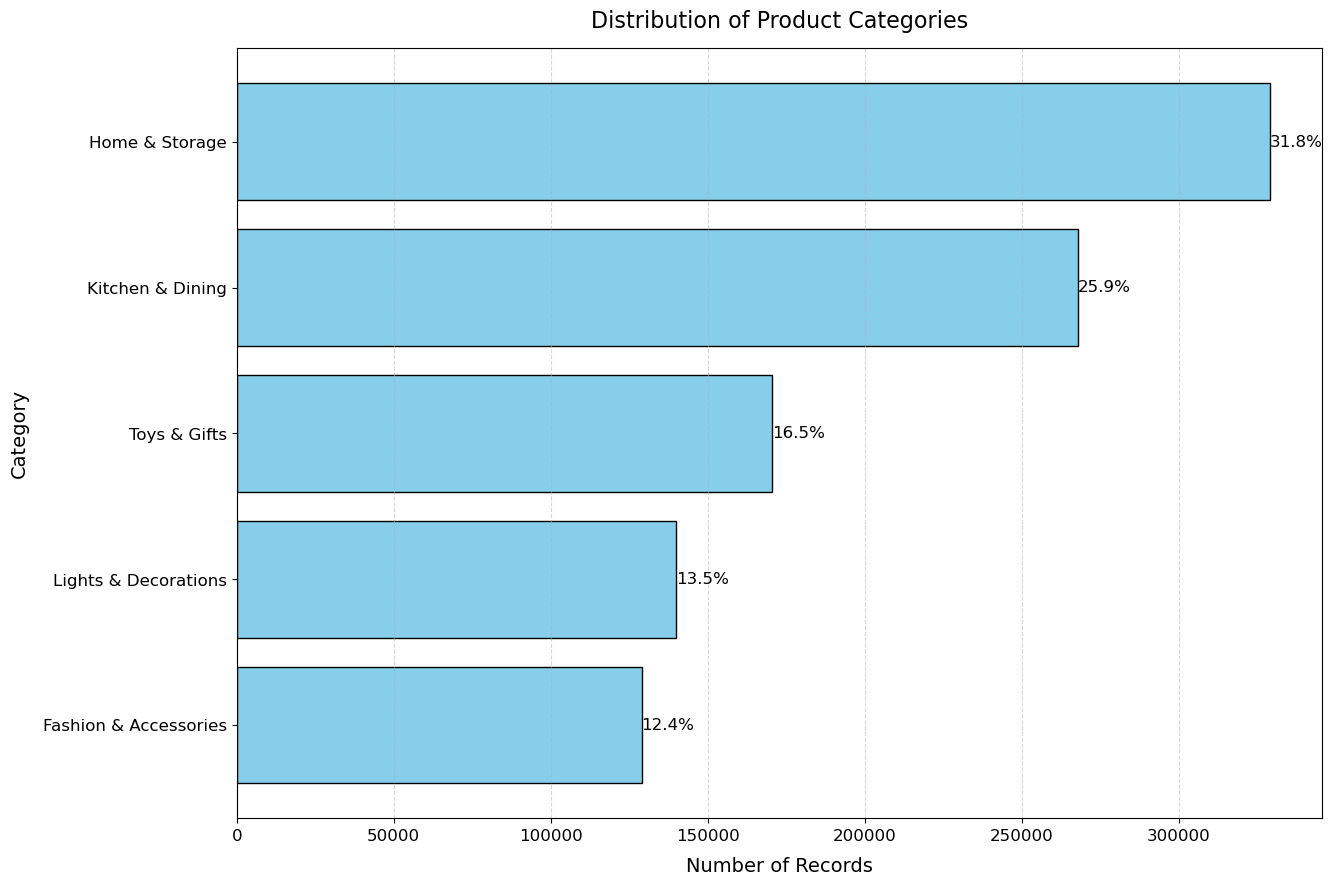

In [ ]:
# category_counts = df_merged['Category'].value_counts()
# df_category_counts = category_counts.reset_index()
# df_category_counts.columns = ['Category', 'Count']
# df_category_counts['Percentage'] = (df_category_counts['Count'] / df_category_counts['Count'].sum()) * 100

# df_category_counts = df_category_counts.sort_values('Count', ascending=True)

# plt.figure(figsize=(14, 10))
# plt.barh(df_category_counts['Category'], df_category_counts['Count'], color='skyblue', edgecolor='black')

# for index, value in enumerate(df_category_counts['Count']):
#     plt.text(value + 10, index, f"{df_category_counts['Percentage'].iloc[index]:.1f}%", fontsize=12, va='center')

# plt.xlabel("Number of Records", fontsize=14, labelpad=10)
# plt.ylabel("Category", fontsize=14, labelpad=10)
# plt.title("Distribution of Product Categories", fontsize=16, pad=15)
# plt.grid(axis="x", linestyle="--", alpha=0.5)
# plt.xticks(fontsize=12)
# plt.yticks(fontsize=12)

# # Show the plot
# plt.show()

In [ ]:
# df_category_counts

,Category,Count,Percentage
4,Fashion & Accessories,128928,12.442854
3,Lights & Decorations,139766,13.488830
2,Toys & Gifts,170527,16.457578
1,Kitchen & Dining,267853,25.850519
0,Home & Storage,329087,31.760219


## Check Data

After categorizing products into five distinct categories, we analyze their sales trends over time using time series plots. In addition, we check the frequency components of sales fluctuations by computing the Power Spectral Density for each category in order to identify potential seasonal patterns, periodic trends, and demand cycles if any in the dataset.

In [13]:
df_merged['InvoiceDate'] = pd.to_datetime(df_merged['InvoiceDate'])

# categories_time_series = df_merged.groupby(['Category', pd.Grouper(key='InvoiceDate', freq='D')]) \
#     .agg({'Sales': 'sum'}).reset_index()

# categories = categories_time_series['Category'].unique()

# for category in categories:
#     df_category = categories_time_series[categories_time_series['Category'] == category].dropna()

#     if df_category.empty:
#         continue

#     fs = 1  # Sampling frequency (1 per day)

#     if len(df_category) > 1:
#         f, Pxx = welch(df_category['Sales'].fillna(0), fs=fs, nperseg=min(len(df_category), 256))

#         fig, ax = plt.subplots(1, 2, figsize=(14, 5))

#         # Time Series
#         ax[0].plot(df_category['InvoiceDate'], df_category['Sales'], label=f'{category} Sales', color='b')
#         ax[0].set_xlabel('Date')
#         ax[0].set_ylabel('Total Sales Sold')
#         ax[0].set_title(f'Time Series of Sales for {category}')
#         ax[0].grid()

#         # PSD
#         ax[1].semilogy(f, Pxx, color='r')
#         ax[1].set_xlabel('Frequency (cycles per day)')
#         ax[1].set_ylabel('Power Spectral Density')
#         ax[1].set_title(f'PSD of Sales for {category}')
#         ax[1].grid()

#         plt.tight_layout()
#         plt.show()

- **For products in Fashion & Accessories**, the Time Series plot shows that there are periodic peaks in sales, suggesting seasonal or promotional effects. However, the baseline sales remain relatively stable over time. And its PSD indicate there is significant power at low frequencies. It shows long-term trends rather than short-term fluctuations.

- **For products in Home & Storage**, they exhibits a stable sales trend with occasional peaks, possibly due to special promotions or holiday sales. Based on PSD plot, the strong power at low frequencies suggests there is steady demand with periodic fluctuations.

- **For products in Kitchen & Dining**, the Time Series plot shows large spikes at certain points, likely driven by seasonal demand, such as holiday cooking and dining events. The PSD plot reveals high variance in power, suggesting both long-term trends and short-term variations, indicating seasonal shopping behavior.

- **For products in Lights & Decorations**, the Time Series plot displays a noticeable upward trend towards the latter part of the time frame, suggesting increased sales during festive seasons. The PSD plot confirms strong periodic components, indicating a high dependence on seasonal trends, likely influenced by holidays and special events.

- **For products in Toys & Gifts**, the Time Series plot highlights sharp sales spikes, particularly around the holiday season, reflecting high demand during gift-giving periods. The PSD plot shows strong periodic components, reinforcing the idea that purchasing behavior in this category is significantly influenced by seasonal celebrations and special occasions.

In [ ]:
# df_merged.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Country,Sales,Year,Month,Category
0,489434,85048,15cm christmas glass ball 20 lights,12,2009-12-01 07:45:00,6.95,United Kingdom,83.40,2009,12,Lights & Decorations
1,489559,85048,15cm christmas glass ball 20 lights,12,2009-12-01 12:55:00,6.95,United Kingdom,83.40,2009,12,Lights & Decorations
2,489576,85048,15cm christmas glass ball 20 lights,5,2009-12-01 13:38:00,7.95,United Kingdom,39.75,2009,12,Lights & Decorations
3,489582,85048,15cm christmas glass ball 20 lights,2,2009-12-01 13:47:00,7.95,United Kingdom,15.90,2009,12,Lights & Decorations
4,489597,85048,15cm christmas glass ball 20 lights,1,2009-12-01 14:28:00,17.35,United Kingdom,17.35,2009,12,Lights & Decorations


In [14]:
df_home = df_merged[df_merged['Category'] == 'Home & Storage']
df_fashion = df_merged[df_merged['Category'] == 'Fashion & Accessories']
df_kitchen = df_merged[df_merged['Category'] == 'Kitchen & Dining']
df_toys = df_merged[df_merged['Category'] == 'Toys & Gifts']
df_lights = df_merged[df_merged['Category'] == 'Lights & Decorations']

In [16]:
df_home.to_csv("home_storage.csv", index=False)
df_fashion.to_csv("fashion_accessories.csv", index=False)
df_kitchen.to_csv("kitchen_dining.csv", index=False)
df_toys.to_csv("toys_gifts.csv", index=False)
df_lights.to_csv("lights_decorations.csv", index=False)

Based on the Augmented Dickey-Fuller (ADF) test results, we can derive key insights into the stationarity of sales data across different product categories.
- **Stationary Categories**: Home & Storage, Fashion & Accessories, and Kitchen & Dining

The ADF test results show that the p-values of these three categires are below 0.05, indicating that these time series are stationary. This suggests that their sales trends remain stable over time without strong long-term trends or seasonality that require differencing.
- **Non-Stationary Categories**: Lights & Decorations and Toys & Gifts

These two categories initially exhibit non-stationarity, as their p-values are greater than 0.05. This suggests the presence of trends or seasonality in these sales data.

After applying first-order differencing, both Lights & Decorations and Toys & Gifts become stationary, as their p-values drop below 0.05. This further proves that these categories experience trends or seasonality, but differencing can help in making the data suitable for forecasting models like ARIMA.

In this way,  we have three categories that are already stationary, simple time series models may work well for them. However, for non-stationary categories that required differencing, more advanced models incorporating trend and seasonal adjustments may be necessary.


## Model

TODO：
1. Clearly define exactly what it is that you are forecasting.
2. Include an Architecture diagram as you build further.
3. Think about training and test data split/strategy.
4. Shift the focus on building forecasting models.
5. Use MAPE to report your results. Since MAPE is a percent error, please report on a scale of 0-100. (Do not report RMSE.)
6. The testing results must be divided into three or four time periods or regions where they are all of the same sizes, for each region report MAPE, and box plot of errors to show the spread.

#### Home & Storage

In [ ]:
df_home = df_merged[df_merged['Category'] == 'Home & Storage']
df_home = df_home.set_index('InvoiceDate')
home_sales = df_home['Sales'].resample('D').sum()
home_sales =home_sales.reset_index()
home_sales.columns = ['ds', 'y']
home_sales['ds'] = pd.to_datetime(home_sales['ds'])
home_sales['y'] = home_sales['y'].astype(float)

In [ ]:
Q1 = home_sales['y'].quantile(0.25)
Q3 = home_sales['y'].quantile(0.75)

IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

home_sales = home_sales[(home_sales['y'] >= lower_bound) & (home_sales['y'] <= upper_bound)]
home_sales = home_sales[home_sales['y'] > 0]

N = len(home_sales)
train_end = int(N * 0.8)
train_df = home_sales.iloc[:train_end].copy()
test_df  = home_sales.iloc[train_end:].copy()
train_df['y'] = np.log1p(train_df['y'])
forecast_days = (test_df['ds'].max() - train_df['ds'].max()).days
print("Number of days to forecast:", forecast_days)

# from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler()
# train_df['y'] = scaler.fit_transform(train_df[['y']])
# test_df['y'] = scaler.transform(test_df[['y']])

# y_mean = scaler.mean_[0]
# y_std = scaler.scale_[0]

# decompose = seasonal_decompose(train_df['y'], model='addictive', extrapolate_trend='freq', period=12)
# decompose.plot().show()

Number of days to forecast: 148


In [ ]:
param_grid = {
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],  # Controls trend flexibility
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],  # Controls seasonal flexibility
    'holidays_prior_scale': [0.01, 0.1, 1.0, 10.0],  # Controls holiday effect flexibility
    'seasonality_mode': ['additive', 'multiplicative']  # Type of seasonality
}

all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
mapes = []

for params in all_params:
    m = Prophet(**params)
    m.add_seasonality(name='quarterly', period=90, fourier_order=6)
    m.add_seasonality(name='half_year', period=180, fourier_order=8)
    m.add_country_holidays(country_name='UK')

    m.fit(train_df)

    df_cv = cross_validation(m, initial='365 days', period='60 days', horizon=f'{forecast_days} days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)

    mapes.append(df_p['mape'].values[0])

tuning_results = pd.DataFrame(all_params)
tuning_results['mape'] = mapes

best_params = tuning_results.sort_values(by='mape').iloc[0]

print("Best Parameters Found:")
print(best_params)
best_params = best_params.drop('mape')
best_params = best_params.to_dict()
m = Prophet(**best_params)
m.add_seasonality(name='quarterly', period=90, fourier_order=6)
m.add_seasonality(name='half_year', period=180, fourier_order=8)
m.add_country_holidays(country_name='UK')

m.fit(train_df)
future = m.make_future_dataframe(periods=forecast_days, freq='D')
forecast = m.predict(future)

forecast[['yhat', 'yhat_lower', 'yhat_upper']] = np.expm1(forecast[['yhat', 'yhat_lower', 'yhat_upper']])
train_df['y'] = np.expm1(train_df['y'])
mape_test = np.mean(np.abs((test_df['y'] - forecast['yhat']) / test_df['y']))
print("Test MAPE:", mape_test * 100, "%")

23:06:56 - cmdstanpy - INFO - Chain [1] start processing
23:06:56 - cmdstanpy - INFO - Chain [1] done processing
23:06:58 - cmdstanpy - INFO - Chain [1] start processing
23:06:58 - cmdstanpy - INFO - Chain [1] start processing
23:06:58 - cmdstanpy - INFO - Chain [1] done processing
23:06:58 - cmdstanpy - INFO - Chain [1] done processing
23:06:58 - cmdstanpy - INFO - Chain [1] start processing
23:06:58 - cmdstanpy - INFO - Chain [1] done processing
23:06:59 - cmdstanpy - INFO - Chain [1] start processing
23:06:59 - cmdstanpy - INFO - Chain [1] start processing
23:06:59 - cmdstanpy - INFO - Chain [1] done processing
23:06:59 - cmdstanpy - INFO - Chain [1] done processing
23:06:59 - cmdstanpy - INFO - Chain [1] start processing
23:06:59 - cmdstanpy - INFO - Chain [1] done processing
23:07:00 - cmdstanpy - INFO - Chain [1] start processing
23:07:00 - cmdstanpy - INFO - Chain [1] start processing
23:07:00 - cmdstanpy - INFO - Chain [1] done processing
23:07:00 - cmdstanpy - INFO - Chain [1]

23:07:27 - cmdstanpy - INFO - Chain [1] done processing
23:07:28 - cmdstanpy - INFO - Chain [1] start processing
23:07:28 - cmdstanpy - INFO - Chain [1] start processing
23:07:28 - cmdstanpy - INFO - Chain [1] done processing
23:07:28 - cmdstanpy - INFO - Chain [1] done processing
23:07:28 - cmdstanpy - INFO - Chain [1] start processing
23:07:28 - cmdstanpy - INFO - Chain [1] done processing
23:07:29 - cmdstanpy - INFO - Chain [1] start processing
23:07:29 - cmdstanpy - INFO - Chain [1] start processing
23:07:29 - cmdstanpy - INFO - Chain [1] done processing
23:07:29 - cmdstanpy - INFO - Chain [1] done processing
23:07:29 - cmdstanpy - INFO - Chain [1] start processing
23:07:29 - cmdstanpy - INFO - Chain [1] done processing
23:07:30 - cmdstanpy - INFO - Chain [1] start processing
23:07:30 - cmdstanpy - INFO - Chain [1] start processing
23:07:30 - cmdstanpy - INFO - Chain [1] done processing
23:07:30 - cmdstanpy - INFO - Chain [1] done processing
23:07:30 - cmdstanpy - INFO - Chain [1] 

23:07:57 - cmdstanpy - INFO - Chain [1] start processing
23:07:57 - cmdstanpy - INFO - Chain [1] done processing
23:07:58 - cmdstanpy - INFO - Chain [1] start processing
23:07:58 - cmdstanpy - INFO - Chain [1] start processing
23:07:58 - cmdstanpy - INFO - Chain [1] done processing
23:07:58 - cmdstanpy - INFO - Chain [1] done processing
23:07:58 - cmdstanpy - INFO - Chain [1] start processing
23:07:58 - cmdstanpy - INFO - Chain [1] done processing
23:07:59 - cmdstanpy - INFO - Chain [1] start processing
23:07:59 - cmdstanpy - INFO - Chain [1] start processing
23:07:59 - cmdstanpy - INFO - Chain [1] done processing
23:07:59 - cmdstanpy - INFO - Chain [1] done processing
23:08:00 - cmdstanpy - INFO - Chain [1] start processing
23:08:00 - cmdstanpy - INFO - Chain [1] done processing
23:08:02 - cmdstanpy - INFO - Chain [1] start processing
23:08:02 - cmdstanpy - INFO - Chain [1] start processing
23:08:02 - cmdstanpy - INFO - Chain [1] done processing
23:08:02 - cmdstanpy - INFO - Chain [1]

23:08:32 - cmdstanpy - INFO - Chain [1] done processing
23:08:33 - cmdstanpy - INFO - Chain [1] start processing
23:08:33 - cmdstanpy - INFO - Chain [1] start processing
23:08:33 - cmdstanpy - INFO - Chain [1] done processing
23:08:33 - cmdstanpy - INFO - Chain [1] done processing
23:08:34 - cmdstanpy - INFO - Chain [1] start processing
23:08:34 - cmdstanpy - INFO - Chain [1] done processing
23:08:35 - cmdstanpy - INFO - Chain [1] start processing
23:08:35 - cmdstanpy - INFO - Chain [1] start processing
23:08:35 - cmdstanpy - INFO - Chain [1] done processing
23:08:35 - cmdstanpy - INFO - Chain [1] done processing
23:08:35 - cmdstanpy - INFO - Chain [1] start processing
23:08:35 - cmdstanpy - INFO - Chain [1] done processing
23:08:36 - cmdstanpy - INFO - Chain [1] start processing
23:08:36 - cmdstanpy - INFO - Chain [1] start processing
23:08:36 - cmdstanpy - INFO - Chain [1] done processing
23:08:36 - cmdstanpy - INFO - Chain [1] done processing
23:08:36 - cmdstanpy - INFO - Chain [1] 

23:09:06 - cmdstanpy - INFO - Chain [1] start processing
23:09:06 - cmdstanpy - INFO - Chain [1] done processing
23:09:07 - cmdstanpy - INFO - Chain [1] start processing
23:09:07 - cmdstanpy - INFO - Chain [1] start processing
23:09:07 - cmdstanpy - INFO - Chain [1] done processing
23:09:07 - cmdstanpy - INFO - Chain [1] done processing
23:09:07 - cmdstanpy - INFO - Chain [1] start processing
23:09:07 - cmdstanpy - INFO - Chain [1] done processing
23:09:08 - cmdstanpy - INFO - Chain [1] start processing
23:09:08 - cmdstanpy - INFO - Chain [1] start processing
23:09:08 - cmdstanpy - INFO - Chain [1] done processing
23:09:08 - cmdstanpy - INFO - Chain [1] done processing
23:09:08 - cmdstanpy - INFO - Chain [1] start processing
23:09:08 - cmdstanpy - INFO - Chain [1] done processing
23:09:09 - cmdstanpy - INFO - Chain [1] start processing
23:09:09 - cmdstanpy - INFO - Chain [1] start processing
23:09:09 - cmdstanpy - INFO - Chain [1] done processing
23:09:09 - cmdstanpy - INFO - Chain [1]

23:09:39 - cmdstanpy - INFO - Chain [1] done processing
23:09:39 - cmdstanpy - INFO - Chain [1] start processing
23:09:39 - cmdstanpy - INFO - Chain [1] start processing
23:09:40 - cmdstanpy - INFO - Chain [1] done processing
23:09:40 - cmdstanpy - INFO - Chain [1] done processing
23:09:40 - cmdstanpy - INFO - Chain [1] start processing
23:09:40 - cmdstanpy - INFO - Chain [1] done processing
23:09:41 - cmdstanpy - INFO - Chain [1] start processing
23:09:41 - cmdstanpy - INFO - Chain [1] start processing
23:09:41 - cmdstanpy - INFO - Chain [1] done processing
23:09:41 - cmdstanpy - INFO - Chain [1] done processing
23:09:41 - cmdstanpy - INFO - Chain [1] start processing
23:09:41 - cmdstanpy - INFO - Chain [1] done processing
23:09:42 - cmdstanpy - INFO - Chain [1] start processing
23:09:42 - cmdstanpy - INFO - Chain [1] start processing
23:09:42 - cmdstanpy - INFO - Chain [1] done processing
23:09:42 - cmdstanpy - INFO - Chain [1] done processing
23:09:42 - cmdstanpy - INFO - Chain [1] 

Best Parameters Found:
changepoint_prior_scale             0.001
seasonality_prior_scale              10.0
holidays_prior_scale                 10.0
seasonality_mode           multiplicative
mape                             0.042319
Name: 31, dtype: object
Test MAPE: 45.692628601067156 %


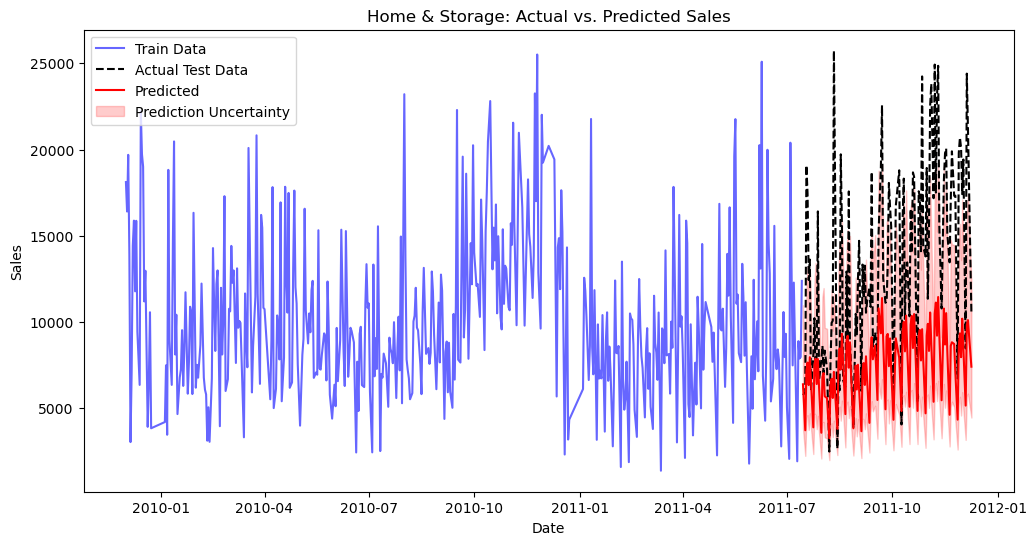

In [ ]:
test_df['ds'] = pd.to_datetime(test_df['ds'])
forecast['ds'] = pd.to_datetime(forecast['ds'])
forecast_test = forecast.set_index('ds').reindex(test_df['ds'])

plt.figure(figsize=(12, 6))
plt.plot(train_df['ds'], train_df['y'], label='Train Data', color='blue', alpha=0.6)
plt.plot(test_df['ds'], test_df['y'], label='Actual Test Data', color='black', linestyle='dashed')
plt.plot(forecast_test.index, forecast_test['yhat'], label='Predicted', color='red')
plt.fill_between(forecast_test.index, forecast_test['yhat_lower'], forecast_test['yhat_upper'],
                 color='red', alpha=0.2, label='Prediction Uncertainty')

plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Home & Storage: Actual vs. Predicted Sales')
plt.legend()
plt.show()

#### Fashion & Accessories

In [ ]:
df_fashion = df_merged[df_merged['Category'] == 'Fashion & Accessories']
df_fashion = df_fashion.set_index('InvoiceDate')
fashion_sales = df_fashion['Sales'].resample('D').sum()
fashion_sales =fashion_sales.reset_index()
fashion_sales.columns = ['ds', 'y']
fashion_sales['ds'] = pd.to_datetime(fashion_sales['ds'])
fashion_sales['y'] = fashion_sales['y'].astype(float)

In [ ]:
Q1 = fashion_sales['y'].quantile(0.25)
Q3 = fashion_sales['y'].quantile(0.75)

IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

fashion_sales = fashion_sales[(fashion_sales['y'] >= lower_bound) & (fashion_sales['y'] <= upper_bound)]
fashion_sales = fashion_sales[fashion_sales['y'] > 0]

N = len(fashion_sales)
train_end = int(N * 0.8)
train_df = fashion_sales.iloc[:train_end].copy()
test_df  = fashion_sales.iloc[train_end:].copy()
train_df['y'] = np.log1p(train_df['y'])
forecast_days = (test_df['ds'].max() - train_df['ds'].max()).days
print("Number of days to forecast:", forecast_days)

Number of days to forecast: 140


In [ ]:
param_grid = {
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],  # Controls trend flexibility
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],  # Controls seasonal flexibility
    'holidays_prior_scale': [0.01, 0.1, 1.0, 10.0],  # Controls holiday effect flexibility
    'seasonality_mode': ['additive', 'multiplicative']  # Type of seasonality
}

all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
mapes = []

for params in all_params:
    m = Prophet(**params)
    m.add_seasonality(name='quarterly', period=90, fourier_order=6)
    m.add_seasonality(name='half_year', period=180, fourier_order=8)
    m.add_country_holidays(country_name='UK')

    m.fit(train_df)

    df_cv = cross_validation(m, initial='365 days', period='60 days', horizon=f'{forecast_days} days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)

    mapes.append(df_p['mape'].values[0])

tuning_results = pd.DataFrame(all_params)
tuning_results['mape'] = mapes

best_params = tuning_results.sort_values(by='mape').iloc[0]

print("Best Parameters Found:")
print(best_params)
best_params = best_params.drop('mape')
best_params = best_params.to_dict()
m = Prophet(**best_params)
m.add_seasonality(name='quarterly', period=90, fourier_order=6)
m.add_seasonality(name='half_year', period=180, fourier_order=8)
m.add_country_holidays(country_name='UK')

m.fit(train_df)
future = m.make_future_dataframe(periods=forecast_days, freq='D')
forecast = m.predict(future)

forecast[['yhat', 'yhat_lower', 'yhat_upper']] = np.expm1(forecast[['yhat', 'yhat_lower', 'yhat_upper']])
train_df['y'] = np.expm1(train_df['y'])

merged_df = pd.merge(test_df[['ds', 'y']], forecast[['ds', 'yhat']], on='ds', how='inner')
mape_test = np.mean(np.abs((merged_df['y'] - merged_df['yhat']) / merged_df['y']))
print("Test MAPE:", mape_test * 100, "%")

23:09:47 - cmdstanpy - INFO - Chain [1] start processing
23:09:47 - cmdstanpy - INFO - Chain [1] done processing
23:09:48 - cmdstanpy - INFO - Chain [1] start processing
23:09:48 - cmdstanpy - INFO - Chain [1] start processing
23:09:48 - cmdstanpy - INFO - Chain [1] done processing
23:09:48 - cmdstanpy - INFO - Chain [1] done processing
23:09:49 - cmdstanpy - INFO - Chain [1] start processing
23:09:49 - cmdstanpy - INFO - Chain [1] done processing
23:09:50 - cmdstanpy - INFO - Chain [1] start processing
23:09:50 - cmdstanpy - INFO - Chain [1] start processing
23:09:50 - cmdstanpy - INFO - Chain [1] done processing
23:09:50 - cmdstanpy - INFO - Chain [1] done processing
23:09:50 - cmdstanpy - INFO - Chain [1] start processing
23:09:50 - cmdstanpy - INFO - Chain [1] done processing
23:09:51 - cmdstanpy - INFO - Chain [1] start processing
23:09:51 - cmdstanpy - INFO - Chain [1] start processing
23:09:51 - cmdstanpy - INFO - Chain [1] done processing
23:09:51 - cmdstanpy - INFO - Chain [1]

23:10:18 - cmdstanpy - INFO - Chain [1] done processing
23:10:19 - cmdstanpy - INFO - Chain [1] start processing
23:10:19 - cmdstanpy - INFO - Chain [1] start processing
23:10:19 - cmdstanpy - INFO - Chain [1] done processing
23:10:19 - cmdstanpy - INFO - Chain [1] done processing
23:10:19 - cmdstanpy - INFO - Chain [1] start processing
23:10:19 - cmdstanpy - INFO - Chain [1] done processing
23:10:20 - cmdstanpy - INFO - Chain [1] start processing
23:10:20 - cmdstanpy - INFO - Chain [1] start processing
23:10:20 - cmdstanpy - INFO - Chain [1] done processing
23:10:20 - cmdstanpy - INFO - Chain [1] done processing
23:10:20 - cmdstanpy - INFO - Chain [1] start processing
23:10:20 - cmdstanpy - INFO - Chain [1] done processing
23:10:21 - cmdstanpy - INFO - Chain [1] start processing
23:10:21 - cmdstanpy - INFO - Chain [1] start processing
23:10:21 - cmdstanpy - INFO - Chain [1] done processing
23:10:21 - cmdstanpy - INFO - Chain [1] done processing
23:10:21 - cmdstanpy - INFO - Chain [1] 

23:25:35 - cmdstanpy - INFO - Chain [1] start processing
23:25:35 - cmdstanpy - INFO - Chain [1] done processing
23:25:36 - cmdstanpy - INFO - Chain [1] start processing
23:25:36 - cmdstanpy - INFO - Chain [1] start processing
23:25:36 - cmdstanpy - INFO - Chain [1] done processing
23:25:36 - cmdstanpy - INFO - Chain [1] done processing
23:25:36 - cmdstanpy - INFO - Chain [1] start processing
23:25:36 - cmdstanpy - INFO - Chain [1] done processing
23:25:37 - cmdstanpy - INFO - Chain [1] start processing
23:25:37 - cmdstanpy - INFO - Chain [1] start processing
23:25:37 - cmdstanpy - INFO - Chain [1] done processing
23:25:37 - cmdstanpy - INFO - Chain [1] done processing
23:25:38 - cmdstanpy - INFO - Chain [1] start processing
23:25:38 - cmdstanpy - INFO - Chain [1] done processing
23:25:39 - cmdstanpy - INFO - Chain [1] start processing
23:25:39 - cmdstanpy - INFO - Chain [1] start processing
23:25:39 - cmdstanpy - INFO - Chain [1] done processing
23:25:39 - cmdstanpy - INFO - Chain [1]

23:26:05 - cmdstanpy - INFO - Chain [1] done processing
23:26:06 - cmdstanpy - INFO - Chain [1] start processing
23:26:06 - cmdstanpy - INFO - Chain [1] start processing
23:26:06 - cmdstanpy - INFO - Chain [1] done processing
23:26:06 - cmdstanpy - INFO - Chain [1] done processing
23:26:06 - cmdstanpy - INFO - Chain [1] start processing
23:26:06 - cmdstanpy - INFO - Chain [1] done processing
23:26:07 - cmdstanpy - INFO - Chain [1] start processing
23:26:07 - cmdstanpy - INFO - Chain [1] start processing
23:26:07 - cmdstanpy - INFO - Chain [1] done processing
23:26:07 - cmdstanpy - INFO - Chain [1] done processing
23:26:07 - cmdstanpy - INFO - Chain [1] start processing
23:26:08 - cmdstanpy - INFO - Chain [1] done processing
23:26:08 - cmdstanpy - INFO - Chain [1] start processing
23:26:08 - cmdstanpy - INFO - Chain [1] start processing
23:26:08 - cmdstanpy - INFO - Chain [1] done processing
23:26:09 - cmdstanpy - INFO - Chain [1] done processing
23:26:09 - cmdstanpy - INFO - Chain [1] 

23:26:37 - cmdstanpy - INFO - Chain [1] start processing
23:26:37 - cmdstanpy - INFO - Chain [1] done processing
23:26:38 - cmdstanpy - INFO - Chain [1] start processing
23:26:38 - cmdstanpy - INFO - Chain [1] start processing
23:26:38 - cmdstanpy - INFO - Chain [1] done processing
23:26:38 - cmdstanpy - INFO - Chain [1] done processing
23:26:38 - cmdstanpy - INFO - Chain [1] start processing
23:26:38 - cmdstanpy - INFO - Chain [1] done processing
23:26:39 - cmdstanpy - INFO - Chain [1] start processing
23:26:39 - cmdstanpy - INFO - Chain [1] start processing
23:26:39 - cmdstanpy - INFO - Chain [1] done processing
23:26:39 - cmdstanpy - INFO - Chain [1] done processing
23:26:39 - cmdstanpy - INFO - Chain [1] start processing
23:26:39 - cmdstanpy - INFO - Chain [1] done processing
23:26:40 - cmdstanpy - INFO - Chain [1] start processing
23:26:40 - cmdstanpy - INFO - Chain [1] start processing
23:26:40 - cmdstanpy - INFO - Chain [1] done processing
23:26:40 - cmdstanpy - INFO - Chain [1]

23:27:08 - cmdstanpy - INFO - Chain [1] done processing
23:27:09 - cmdstanpy - INFO - Chain [1] start processing
23:27:09 - cmdstanpy - INFO - Chain [1] start processing
23:27:09 - cmdstanpy - INFO - Chain [1] done processing
23:27:09 - cmdstanpy - INFO - Chain [1] done processing
23:27:09 - cmdstanpy - INFO - Chain [1] start processing
23:27:09 - cmdstanpy - INFO - Chain [1] done processing
23:27:10 - cmdstanpy - INFO - Chain [1] start processing
23:27:10 - cmdstanpy - INFO - Chain [1] start processing
23:27:10 - cmdstanpy - INFO - Chain [1] done processing
23:27:10 - cmdstanpy - INFO - Chain [1] done processing
23:27:11 - cmdstanpy - INFO - Chain [1] start processing
23:27:11 - cmdstanpy - INFO - Chain [1] done processing
23:27:12 - cmdstanpy - INFO - Chain [1] start processing
23:27:12 - cmdstanpy - INFO - Chain [1] start processing
23:27:12 - cmdstanpy - INFO - Chain [1] done processing
23:27:12 - cmdstanpy - INFO - Chain [1] done processing
23:27:12 - cmdstanpy - INFO - Chain [1] 

Best Parameters Found:
changepoint_prior_scale             0.001
seasonality_prior_scale              10.0
holidays_prior_scale                 10.0
seasonality_mode           multiplicative
mape                             0.050074
Name: 31, dtype: object
Test MAPE: 45.98880587126704 %


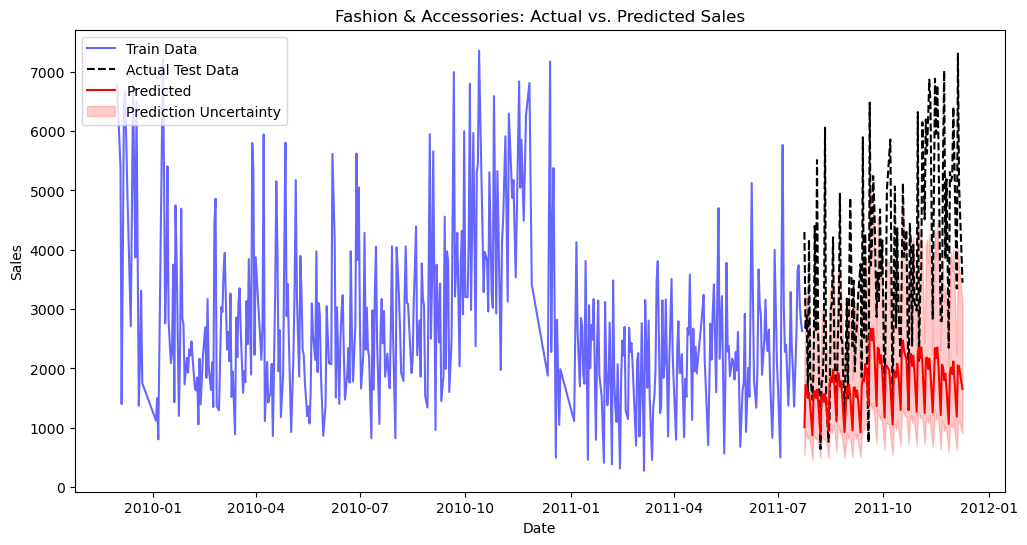

In [ ]:
test_df['ds'] = pd.to_datetime(test_df['ds'])
forecast['ds'] = pd.to_datetime(forecast['ds'])
forecast_test = forecast.set_index('ds').reindex(test_df['ds'])

plt.figure(figsize=(12, 6))
plt.plot(train_df['ds'], train_df['y'], label='Train Data', color='blue', alpha=0.6)
plt.plot(test_df['ds'], test_df['y'], label='Actual Test Data', color='black', linestyle='dashed')
plt.plot(forecast_test.index, forecast_test['yhat'], label='Predicted', color='red')
plt.fill_between(forecast_test.index, forecast_test['yhat_lower'], forecast_test['yhat_upper'],
                 color='red', alpha=0.2, label='Prediction Uncertainty')

plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Fashion & Accessories: Actual vs. Predicted Sales')
plt.legend()
plt.show()

#### Kitchen & Dining

In [ ]:
df_kitchen = df_merged[df_merged['Category'] == 'Kitchen & Dining']
df_kitchen = df_kitchen.set_index('InvoiceDate')
kitchen_sales = df_kitchen['Sales'].resample('D').sum()
kitchen_sales =kitchen_sales.reset_index()
kitchen_sales.columns = ['ds', 'y']
kitchen_sales['ds'] = pd.to_datetime(kitchen_sales['ds'])
kitchen_sales['y'] = kitchen_sales['y'].astype(float)

In [ ]:
Q1 = kitchen_sales['y'].quantile(0.25)
Q3 = kitchen_sales['y'].quantile(0.75)

IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

kitchen_sales = kitchen_sales[(kitchen_sales['y'] >= lower_bound) & (kitchen_sales['y'] <= upper_bound)]
kitchen_sales = kitchen_sales[kitchen_sales['y'] > 0]

N = len(kitchen_sales)
train_end = int(N * 0.8)
train_df = kitchen_sales.iloc[:train_end].copy()
test_df  = kitchen_sales.iloc[train_end:].copy()
train_df['y'] = np.log1p(train_df['y'])
forecast_days = (test_df['ds'].max() - train_df['ds'].max()).days
print("Number of days to forecast:", forecast_days)

Number of days to forecast: 141


In [ ]:
param_grid = {
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],  # Controls trend flexibility
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],  # Controls seasonal flexibility
    'holidays_prior_scale': [0.01, 0.1, 1.0, 10.0],  # Controls holiday effect flexibility
    'seasonality_mode': ['additive', 'multiplicative']  # Type of seasonality
}

all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
mapes = []

for params in all_params:
    m = Prophet(**params)
    m.add_seasonality(name='quarterly', period=90, fourier_order=6)
    m.add_seasonality(name='half_year', period=180, fourier_order=8)
    m.add_country_holidays(country_name='UK')

    m.fit(train_df)

    df_cv = cross_validation(m, initial='365 days', period='60 days', horizon=f'{forecast_days} days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)

    mapes.append(df_p['mape'].values[0])

tuning_results = pd.DataFrame(all_params)
tuning_results['mape'] = mapes

best_params = tuning_results.sort_values(by='mape').iloc[0]

print("Best Parameters Found:")
print(best_params)
best_params = best_params.drop('mape')
best_params = best_params.to_dict()
m = Prophet(**best_params)
m.add_seasonality(name='quarterly', period=90, fourier_order=6)
m.add_seasonality(name='half_year', period=180, fourier_order=8)
m.add_country_holidays(country_name='UK')

m.fit(train_df)
future = m.make_future_dataframe(periods=forecast_days, freq='D')
forecast = m.predict(future)

forecast[['yhat', 'yhat_lower', 'yhat_upper']] = np.expm1(forecast[['yhat', 'yhat_lower', 'yhat_upper']])
train_df['y'] = np.expm1(train_df['y'])
mape_test = np.mean(np.abs((test_df['y'] - forecast['yhat']) / test_df['y']))
print("Test MAPE:", mape_test * 100, "%")

23:27:16 - cmdstanpy - INFO - Chain [1] start processing
23:27:16 - cmdstanpy - INFO - Chain [1] done processing
23:27:17 - cmdstanpy - INFO - Chain [1] start processing
23:27:17 - cmdstanpy - INFO - Chain [1] start processing
23:27:17 - cmdstanpy - INFO - Chain [1] done processing
23:27:17 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
23:27:17 - cmdstanpy - INFO - Chain [1] done processing
23:27:17 - cmdstanpy - INFO - Chain [1] start processing
23:27:18 - cmdstanpy - INFO - Chain [1] done processing
23:27:18 - cmdstanpy - INFO - Chain [1] start processing
23:27:18 - cmdstanpy - INFO - Chain [1] done processing
23:27:19 - cmdstanpy - INFO - Chain [1] start processing
23:27:19 - cmdstanpy - INFO - Chain [1] start processing
23:27:19 - cmdstanpy - INFO - Chain [1] done processing
23:27:19 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization 

23:27:43 - cmdstanpy - INFO - Chain [1] done processing
23:27:43 - cmdstanpy - INFO - Chain [1] start processing
23:27:43 - cmdstanpy - INFO - Chain [1] done processing
23:27:44 - cmdstanpy - INFO - Chain [1] start processing
23:27:44 - cmdstanpy - INFO - Chain [1] start processing
23:27:44 - cmdstanpy - INFO - Chain [1] done processing
23:27:44 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
23:27:44 - cmdstanpy - INFO - Chain [1] done processing
23:27:44 - cmdstanpy - INFO - Chain [1] start processing
23:27:44 - cmdstanpy - INFO - Chain [1] done processing
23:27:45 - cmdstanpy - INFO - Chain [1] start processing
23:27:45 - cmdstanpy - INFO - Chain [1] done processing
23:27:45 - cmdstanpy - INFO - Chain [1] start processing
23:27:45 - cmdstanpy - INFO - Chain [1] start processing
23:27:45 - cmdstanpy - INFO - Chain [1] done processing
23:27:45 - cmdstanpy - ERROR - Chain [1] error: error

23:28:10 - cmdstanpy - INFO - Chain [1] done processing
23:28:11 - cmdstanpy - INFO - Chain [1] start processing
23:28:11 - cmdstanpy - INFO - Chain [1] done processing
23:28:12 - cmdstanpy - INFO - Chain [1] start processing
23:28:12 - cmdstanpy - INFO - Chain [1] start processing
23:28:12 - cmdstanpy - INFO - Chain [1] done processing
23:28:12 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
23:28:12 - cmdstanpy - INFO - Chain [1] done processing
23:28:12 - cmdstanpy - INFO - Chain [1] start processing
23:28:13 - cmdstanpy - INFO - Chain [1] done processing
23:28:13 - cmdstanpy - INFO - Chain [1] start processing
23:28:13 - cmdstanpy - INFO - Chain [1] done processing
23:28:14 - cmdstanpy - INFO - Chain [1] start processing
23:28:14 - cmdstanpy - INFO - Chain [1] start processing
23:28:14 - cmdstanpy - INFO - Chain [1] done processing
23:28:14 - cmdstanpy - ERROR - Chain [1] error: error

23:28:40 - cmdstanpy - INFO - Chain [1] start processing
23:28:40 - cmdstanpy - INFO - Chain [1] done processing
23:28:41 - cmdstanpy - INFO - Chain [1] start processing
23:28:41 - cmdstanpy - INFO - Chain [1] start processing
23:28:41 - cmdstanpy - INFO - Chain [1] done processing
23:28:41 - cmdstanpy - INFO - Chain [1] done processing
23:28:41 - cmdstanpy - INFO - Chain [1] start processing
23:28:41 - cmdstanpy - INFO - Chain [1] done processing
23:28:42 - cmdstanpy - INFO - Chain [1] start processing
23:28:42 - cmdstanpy - INFO - Chain [1] start processing
23:28:42 - cmdstanpy - INFO - Chain [1] done processing
23:28:42 - cmdstanpy - INFO - Chain [1] done processing
23:28:42 - cmdstanpy - INFO - Chain [1] start processing
23:28:42 - cmdstanpy - INFO - Chain [1] done processing
23:28:43 - cmdstanpy - INFO - Chain [1] start processing
23:28:43 - cmdstanpy - INFO - Chain [1] start processing
23:28:43 - cmdstanpy - INFO - Chain [1] done processing
23:28:43 - cmdstanpy - INFO - Chain [1]

23:29:10 - cmdstanpy - INFO - Chain [1] done processing
23:29:11 - cmdstanpy - INFO - Chain [1] start processing
23:29:11 - cmdstanpy - INFO - Chain [1] start processing
23:29:11 - cmdstanpy - INFO - Chain [1] done processing
23:29:11 - cmdstanpy - INFO - Chain [1] done processing
23:29:11 - cmdstanpy - INFO - Chain [1] start processing
23:29:11 - cmdstanpy - INFO - Chain [1] done processing
23:29:12 - cmdstanpy - INFO - Chain [1] start processing
23:29:12 - cmdstanpy - INFO - Chain [1] start processing
23:29:12 - cmdstanpy - INFO - Chain [1] done processing
23:29:12 - cmdstanpy - INFO - Chain [1] done processing
23:29:13 - cmdstanpy - INFO - Chain [1] start processing
23:29:13 - cmdstanpy - INFO - Chain [1] done processing
23:29:14 - cmdstanpy - INFO - Chain [1] start processing
23:29:14 - cmdstanpy - INFO - Chain [1] start processing
23:29:14 - cmdstanpy - INFO - Chain [1] done processing
23:29:14 - cmdstanpy - INFO - Chain [1] done processing
23:29:14 - cmdstanpy - INFO - Chain [1] 

23:30:37 - cmdstanpy - INFO - Chain [1] start processing
23:30:37 - cmdstanpy - INFO - Chain [1] done processing
23:30:38 - cmdstanpy - INFO - Chain [1] start processing
23:30:38 - cmdstanpy - INFO - Chain [1] start processing
23:30:39 - cmdstanpy - INFO - Chain [1] done processing
23:30:39 - cmdstanpy - INFO - Chain [1] done processing
23:30:39 - cmdstanpy - INFO - Chain [1] start processing
23:30:39 - cmdstanpy - INFO - Chain [1] done processing
23:30:40 - cmdstanpy - INFO - Chain [1] start processing
23:30:40 - cmdstanpy - INFO - Chain [1] start processing
23:30:40 - cmdstanpy - INFO - Chain [1] done processing
23:30:40 - cmdstanpy - INFO - Chain [1] done processing
23:30:40 - cmdstanpy - INFO - Chain [1] start processing
23:30:40 - cmdstanpy - INFO - Chain [1] done processing
23:30:41 - cmdstanpy - INFO - Chain [1] start processing
23:30:41 - cmdstanpy - INFO - Chain [1] start processing
23:30:41 - cmdstanpy - INFO - Chain [1] done processing
23:30:41 - cmdstanpy - INFO - Chain [1]

23:31:10 - cmdstanpy - INFO - Chain [1] done processing
23:31:11 - cmdstanpy - INFO - Chain [1] start processing
23:31:11 - cmdstanpy - INFO - Chain [1] start processing
23:31:11 - cmdstanpy - INFO - Chain [1] done processing
23:31:11 - cmdstanpy - INFO - Chain [1] done processing
23:31:12 - cmdstanpy - INFO - Chain [1] start processing
23:31:12 - cmdstanpy - INFO - Chain [1] done processing
23:31:13 - cmdstanpy - INFO - Chain [1] start processing
23:31:13 - cmdstanpy - INFO - Chain [1] start processing
23:31:13 - cmdstanpy - INFO - Chain [1] done processing
23:31:13 - cmdstanpy - INFO - Chain [1] done processing
23:31:13 - cmdstanpy - INFO - Chain [1] start processing
23:31:13 - cmdstanpy - INFO - Chain [1] done processing
23:31:14 - cmdstanpy - INFO - Chain [1] start processing
23:31:14 - cmdstanpy - INFO - Chain [1] start processing
23:31:14 - cmdstanpy - INFO - Chain [1] done processing
23:31:14 - cmdstanpy - INFO - Chain [1] done processing
23:31:14 - cmdstanpy - INFO - Chain [1] 

Best Parameters Found:
changepoint_prior_scale               0.5
seasonality_prior_scale               1.0
holidays_prior_scale                 0.01
seasonality_mode           multiplicative
mape                             0.042356
Name: 113, dtype: object
Test MAPE: 72.93974200193863 %


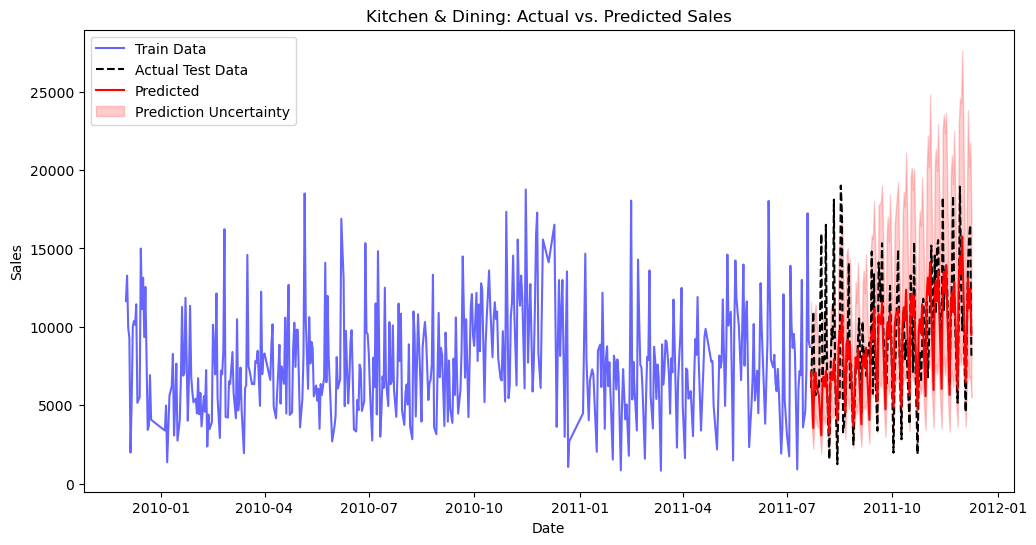

In [ ]:
test_df['ds'] = pd.to_datetime(test_df['ds'])
forecast['ds'] = pd.to_datetime(forecast['ds'])
forecast_test = forecast.set_index('ds').reindex(test_df['ds'])

plt.figure(figsize=(12, 6))
plt.plot(train_df['ds'], train_df['y'], label='Train Data', color='blue', alpha=0.6)
plt.plot(test_df['ds'], test_df['y'], label='Actual Test Data', color='black', linestyle='dashed')
plt.plot(forecast_test.index, forecast_test['yhat'], label='Predicted', color='red')
plt.fill_between(forecast_test.index, forecast_test['yhat_lower'], forecast_test['yhat_upper'],
                 color='red', alpha=0.2, label='Prediction Uncertainty')

plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Kitchen & Dining: Actual vs. Predicted Sales')
plt.legend()
plt.show()

#### Lights & Decorations

In [ ]:
df_light = df_merged[df_merged['Category'] == 'Lights & Decorations']
df_light = df_light.set_index('InvoiceDate')
light_sales = df_light['Sales'].resample('D').sum()
light_sales =light_sales.reset_index()
light_sales.columns = ['ds', 'y']
light_sales['ds'] = pd.to_datetime(light_sales['ds'])
light_sales['y'] = light_sales['y'].astype(float)

In [ ]:
Q1 = light_sales['y'].quantile(0.25)
Q3 = light_sales['y'].quantile(0.75)

IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

light_sales = light_sales[(light_sales['y'] >= lower_bound) & (light_sales['y'] <= upper_bound)]
light_sales = light_sales[light_sales['y'] > 0]

N = len(light_sales)
train_end = int(N * 0.8)
train_df = light_sales.iloc[:train_end].copy()
test_df  = light_sales.iloc[train_end:].copy()
train_df['y'] = np.log1p(train_df['y'])
forecast_days = (test_df['ds'].max() - train_df['ds'].max()).days
print("Number of days to forecast:", forecast_days)

Number of days to forecast: 158


In [ ]:
param_grid = {
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],  # Controls trend flexibility
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],  # Controls seasonal flexibility
    'holidays_prior_scale': [0.01, 0.1, 1.0, 10.0],  # Controls holiday effect flexibility
    'seasonality_mode': ['additive', 'multiplicative']  # Type of seasonality
}

all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
mapes = []

for params in all_params:
    m = Prophet(**params)
    m.add_seasonality(name='quarterly', period=90, fourier_order=6)
    m.add_seasonality(name='half_year', period=180, fourier_order=8)
    m.add_country_holidays(country_name='UK')

    m.fit(train_df)

    df_cv = cross_validation(m, initial='365 days', period='60 days', horizon=f'{forecast_days} days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)

    mapes.append(df_p['mape'].values[0])

tuning_results = pd.DataFrame(all_params)
tuning_results['mape'] = mapes

best_params = tuning_results.sort_values(by='mape').iloc[0]

print("Best Parameters Found:")
print(best_params)
best_params = best_params.drop('mape')
best_params = best_params.to_dict()
m = Prophet(**best_params)
m.add_seasonality(name='quarterly', period=90, fourier_order=6)
m.add_seasonality(name='half_year', period=180, fourier_order=8)
m.add_country_holidays(country_name='UK')

m.fit(train_df)
future = m.make_future_dataframe(periods=forecast_days, freq='D')
forecast = m.predict(future)

forecast[['yhat', 'yhat_lower', 'yhat_upper']] = np.expm1(forecast[['yhat', 'yhat_lower', 'yhat_upper']])
train_df['y'] = np.expm1(train_df['y'])

merged_df = pd.merge(test_df[['ds', 'y']], forecast[['ds', 'yhat']], on='ds', how='inner')
mape_test = np.mean(np.abs((merged_df['y'] - merged_df['yhat']) / merged_df['y']))
print("Test MAPE:", mape_test * 100, "%")

23:31:19 - cmdstanpy - INFO - Chain [1] start processing
23:31:19 - cmdstanpy - INFO - Chain [1] done processing
23:31:20 - cmdstanpy - INFO - Chain [1] start processing
23:31:20 - cmdstanpy - INFO - Chain [1] done processing
23:31:20 - cmdstanpy - INFO - Chain [1] start processing
23:31:20 - cmdstanpy - INFO - Chain [1] done processing
23:31:21 - cmdstanpy - INFO - Chain [1] start processing
23:31:21 - cmdstanpy - INFO - Chain [1] done processing
23:31:21 - cmdstanpy - INFO - Chain [1] start processing
23:31:21 - cmdstanpy - INFO - Chain [1] done processing
23:31:22 - cmdstanpy - INFO - Chain [1] start processing
23:31:22 - cmdstanpy - INFO - Chain [1] done processing
23:31:23 - cmdstanpy - INFO - Chain [1] start processing
23:31:23 - cmdstanpy - INFO - Chain [1] done processing
23:31:24 - cmdstanpy - INFO - Chain [1] start processing
23:31:24 - cmdstanpy - INFO - Chain [1] done processing
23:31:24 - cmdstanpy - INFO - Chain [1] start processing
23:31:24 - cmdstanpy - INFO - Chain [1]

23:32:02 - cmdstanpy - INFO - Chain [1] done processing
23:32:03 - cmdstanpy - INFO - Chain [1] start processing
23:32:03 - cmdstanpy - INFO - Chain [1] done processing
23:32:03 - cmdstanpy - INFO - Chain [1] start processing
23:32:03 - cmdstanpy - INFO - Chain [1] done processing
23:32:04 - cmdstanpy - INFO - Chain [1] start processing
23:32:04 - cmdstanpy - INFO - Chain [1] done processing
23:32:04 - cmdstanpy - INFO - Chain [1] start processing
23:32:04 - cmdstanpy - INFO - Chain [1] done processing
23:32:05 - cmdstanpy - INFO - Chain [1] start processing
23:32:05 - cmdstanpy - INFO - Chain [1] done processing
23:32:06 - cmdstanpy - INFO - Chain [1] start processing
23:32:06 - cmdstanpy - INFO - Chain [1] done processing
23:32:06 - cmdstanpy - INFO - Chain [1] start processing
23:32:07 - cmdstanpy - INFO - Chain [1] done processing
23:32:07 - cmdstanpy - INFO - Chain [1] start processing
23:32:07 - cmdstanpy - INFO - Chain [1] done processing
23:32:08 - cmdstanpy - INFO - Chain [1] 

23:32:47 - cmdstanpy - INFO - Chain [1] start processing
23:32:47 - cmdstanpy - INFO - Chain [1] done processing
23:32:48 - cmdstanpy - INFO - Chain [1] start processing
23:32:48 - cmdstanpy - INFO - Chain [1] done processing
23:32:48 - cmdstanpy - INFO - Chain [1] start processing
23:32:48 - cmdstanpy - INFO - Chain [1] done processing
23:32:49 - cmdstanpy - INFO - Chain [1] start processing
23:32:49 - cmdstanpy - INFO - Chain [1] done processing
23:32:49 - cmdstanpy - INFO - Chain [1] start processing
23:32:49 - cmdstanpy - INFO - Chain [1] done processing
23:32:50 - cmdstanpy - INFO - Chain [1] start processing
23:32:50 - cmdstanpy - INFO - Chain [1] done processing
23:32:51 - cmdstanpy - INFO - Chain [1] start processing
23:32:51 - cmdstanpy - INFO - Chain [1] done processing
23:32:52 - cmdstanpy - INFO - Chain [1] start processing
23:32:52 - cmdstanpy - INFO - Chain [1] done processing
23:32:52 - cmdstanpy - INFO - Chain [1] start processing
23:32:52 - cmdstanpy - INFO - Chain [1]

23:35:19 - cmdstanpy - INFO - Chain [1] done processing
23:35:20 - cmdstanpy - INFO - Chain [1] start processing
23:35:20 - cmdstanpy - INFO - Chain [1] done processing
23:35:20 - cmdstanpy - INFO - Chain [1] start processing
23:35:20 - cmdstanpy - INFO - Chain [1] done processing
23:35:21 - cmdstanpy - INFO - Chain [1] start processing
23:35:21 - cmdstanpy - INFO - Chain [1] done processing
23:35:21 - cmdstanpy - INFO - Chain [1] start processing
23:35:21 - cmdstanpy - INFO - Chain [1] done processing
23:35:22 - cmdstanpy - INFO - Chain [1] start processing
23:35:22 - cmdstanpy - INFO - Chain [1] done processing
23:35:22 - cmdstanpy - INFO - Chain [1] start processing
23:35:23 - cmdstanpy - INFO - Chain [1] done processing
23:35:23 - cmdstanpy - INFO - Chain [1] start processing
23:35:24 - cmdstanpy - INFO - Chain [1] done processing
23:35:24 - cmdstanpy - INFO - Chain [1] start processing
23:35:24 - cmdstanpy - INFO - Chain [1] done processing
23:35:25 - cmdstanpy - INFO - Chain [1] 

Best Parameters Found:
changepoint_prior_scale               0.1
seasonality_prior_scale               0.1
holidays_prior_scale                 10.0
seasonality_mode           multiplicative
mape                             0.050449
Name: 79, dtype: object
Test MAPE: 34.60422578311531 %


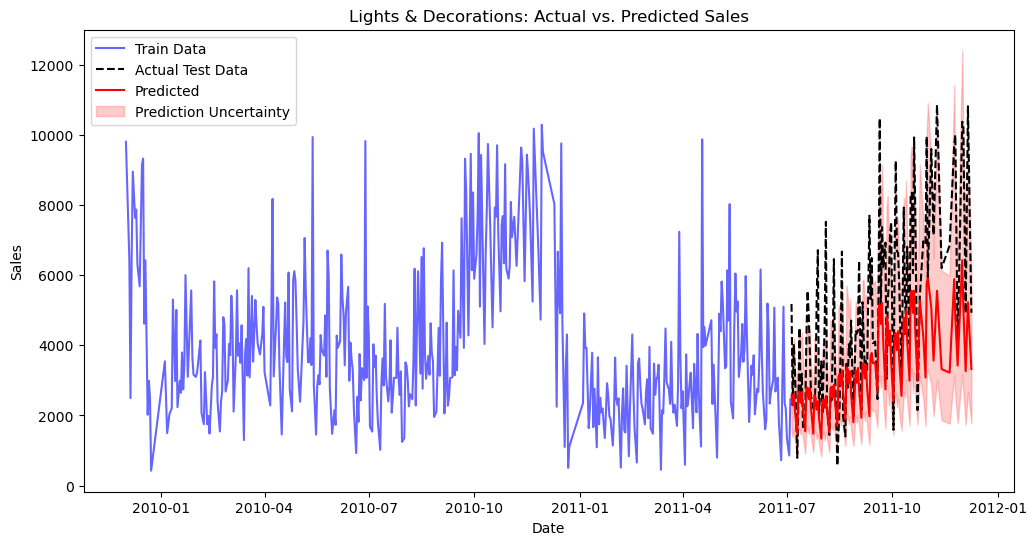

In [ ]:
test_df['ds'] = pd.to_datetime(test_df['ds'])
forecast['ds'] = pd.to_datetime(forecast['ds'])
forecast_test = forecast.set_index('ds').reindex(test_df['ds'])

plt.figure(figsize=(12, 6))
plt.plot(train_df['ds'], train_df['y'], label='Train Data', color='blue', alpha=0.6)
plt.plot(test_df['ds'], test_df['y'], label='Actual Test Data', color='black', linestyle='dashed')
plt.plot(forecast_test.index, forecast_test['yhat'], label='Predicted', color='red')
plt.fill_between(forecast_test.index, forecast_test['yhat_lower'], forecast_test['yhat_upper'],
                 color='red', alpha=0.2, label='Prediction Uncertainty')

plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Lights & Decorations: Actual vs. Predicted Sales')
plt.legend()
plt.show()

#### Toys & Gifts

In [ ]:
df_toy = df_merged[df_merged['Category'] == 'Toys & Gifts']
df_toy = df_toy.set_index('InvoiceDate')
toy_sales = df_toy['Sales'].resample('D').sum()
toy_sales =toy_sales.reset_index()
toy_sales.columns = ['ds', 'y']
toy_sales['ds'] = pd.to_datetime(toy_sales['ds'])
toy_sales['y'] = toy_sales['y'].astype(float)

In [ ]:
Q1 = toy_sales['y'].quantile(0.25)
Q3 = toy_sales['y'].quantile(0.75)

IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

toy_sales = toy_sales[(toy_sales['y'] >= lower_bound) & (toy_sales['y'] <= upper_bound)]
toy_sales = toy_sales[toy_sales['y'] > 0]

N = len(toy_sales)
train_end = int(N * 0.8)
train_df = toy_sales.iloc[:train_end].copy()
test_df  = toy_sales.iloc[train_end:].copy()
train_df['y'] = np.log1p(train_df['y'])
forecast_days = (test_df['ds'].max() - train_df['ds'].max()).days
print("Number of days to forecast:", forecast_days)

Number of days to forecast: 148


In [ ]:
param_grid = {
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],  # Controls trend flexibility
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],  # Controls seasonal flexibility
    'holidays_prior_scale': [0.01, 0.1, 1.0, 10.0],  # Controls holiday effect flexibility
    'seasonality_mode': ['additive', 'multiplicative']  # Type of seasonality
}

all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
mapes = []

for params in all_params:
    m = Prophet(**params)
    m.add_seasonality(name='quarterly', period=90, fourier_order=6)
    m.add_seasonality(name='half_year', period=180, fourier_order=8)
    m.add_country_holidays(country_name='UK')

    m.fit(train_df)

    df_cv = cross_validation(m, initial='365 days', period='60 days', horizon=f'{forecast_days} days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)

    mapes.append(df_p['mape'].values[0])

tuning_results = pd.DataFrame(all_params)
tuning_results['mape'] = mapes

best_params = tuning_results.sort_values(by='mape').iloc[0]

print("Best Parameters Found:")
print(best_params)
best_params = best_params.drop('mape')
best_params = best_params.to_dict()
m = Prophet(**best_params)
m.add_seasonality(name='quarterly', period=90, fourier_order=6)
m.add_seasonality(name='half_year', period=180, fourier_order=8)
m.add_country_holidays(country_name='UK')

m.fit(train_df)
future = m.make_future_dataframe(periods=forecast_days, freq='D')
forecast = m.predict(future)

forecast[['yhat', 'yhat_lower', 'yhat_upper']] = np.expm1(forecast[['yhat', 'yhat_lower', 'yhat_upper']])
train_df['y'] = np.expm1(train_df['y'])
mape_test = np.mean(np.abs((test_df['y'] - forecast['yhat']) / test_df['y']))
print("Test MAPE:", mape_test * 100, "%")

23:35:44 - cmdstanpy - INFO - Chain [1] start processing
23:35:44 - cmdstanpy - INFO - Chain [1] done processing
23:35:45 - cmdstanpy - INFO - Chain [1] start processing
23:35:45 - cmdstanpy - INFO - Chain [1] start processing
23:35:45 - cmdstanpy - INFO - Chain [1] done processing
23:35:45 - cmdstanpy - INFO - Chain [1] done processing
23:35:45 - cmdstanpy - INFO - Chain [1] start processing
23:35:45 - cmdstanpy - INFO - Chain [1] done processing
23:35:46 - cmdstanpy - INFO - Chain [1] start processing
23:35:46 - cmdstanpy - INFO - Chain [1] start processing
23:35:46 - cmdstanpy - INFO - Chain [1] done processing
23:35:46 - cmdstanpy - INFO - Chain [1] done processing
23:35:46 - cmdstanpy - INFO - Chain [1] start processing
23:35:46 - cmdstanpy - INFO - Chain [1] done processing
23:35:47 - cmdstanpy - INFO - Chain [1] start processing
23:35:47 - cmdstanpy - INFO - Chain [1] start processing
23:35:47 - cmdstanpy - INFO - Chain [1] done processing
23:35:47 - cmdstanpy - INFO - Chain [1]

23:36:14 - cmdstanpy - INFO - Chain [1] done processing
23:36:15 - cmdstanpy - INFO - Chain [1] start processing
23:36:15 - cmdstanpy - INFO - Chain [1] start processing
23:36:15 - cmdstanpy - INFO - Chain [1] done processing
23:36:15 - cmdstanpy - INFO - Chain [1] done processing
23:36:15 - cmdstanpy - INFO - Chain [1] start processing
23:36:15 - cmdstanpy - INFO - Chain [1] done processing
23:36:16 - cmdstanpy - INFO - Chain [1] start processing
23:36:16 - cmdstanpy - INFO - Chain [1] start processing
23:36:16 - cmdstanpy - INFO - Chain [1] done processing
23:36:16 - cmdstanpy - INFO - Chain [1] done processing
23:36:16 - cmdstanpy - INFO - Chain [1] start processing
23:36:16 - cmdstanpy - INFO - Chain [1] done processing
23:36:17 - cmdstanpy - INFO - Chain [1] start processing
23:36:17 - cmdstanpy - INFO - Chain [1] start processing
23:36:17 - cmdstanpy - INFO - Chain [1] done processing
23:36:17 - cmdstanpy - INFO - Chain [1] done processing
23:36:17 - cmdstanpy - INFO - Chain [1] 

23:36:45 - cmdstanpy - INFO - Chain [1] start processing
23:36:45 - cmdstanpy - INFO - Chain [1] done processing
23:36:46 - cmdstanpy - INFO - Chain [1] start processing
23:36:46 - cmdstanpy - INFO - Chain [1] start processing
23:36:46 - cmdstanpy - INFO - Chain [1] done processing
23:36:46 - cmdstanpy - INFO - Chain [1] done processing
23:36:47 - cmdstanpy - INFO - Chain [1] start processing
23:36:47 - cmdstanpy - INFO - Chain [1] done processing
23:36:48 - cmdstanpy - INFO - Chain [1] start processing
23:36:48 - cmdstanpy - INFO - Chain [1] start processing
23:36:48 - cmdstanpy - INFO - Chain [1] done processing
23:36:48 - cmdstanpy - INFO - Chain [1] done processing
23:36:48 - cmdstanpy - INFO - Chain [1] start processing
23:36:48 - cmdstanpy - INFO - Chain [1] done processing
23:36:49 - cmdstanpy - INFO - Chain [1] start processing
23:36:49 - cmdstanpy - INFO - Chain [1] start processing
23:36:49 - cmdstanpy - INFO - Chain [1] done processing
23:36:49 - cmdstanpy - INFO - Chain [1]

23:37:15 - cmdstanpy - INFO - Chain [1] done processing
23:37:16 - cmdstanpy - INFO - Chain [1] start processing
23:37:16 - cmdstanpy - INFO - Chain [1] start processing
23:37:16 - cmdstanpy - INFO - Chain [1] done processing
23:37:16 - cmdstanpy - INFO - Chain [1] done processing
23:37:16 - cmdstanpy - INFO - Chain [1] start processing
23:37:16 - cmdstanpy - INFO - Chain [1] done processing
23:37:17 - cmdstanpy - INFO - Chain [1] start processing
23:37:17 - cmdstanpy - INFO - Chain [1] start processing
23:37:17 - cmdstanpy - INFO - Chain [1] done processing
23:37:17 - cmdstanpy - INFO - Chain [1] done processing
23:37:18 - cmdstanpy - INFO - Chain [1] start processing
23:37:18 - cmdstanpy - INFO - Chain [1] done processing
23:37:19 - cmdstanpy - INFO - Chain [1] start processing
23:37:19 - cmdstanpy - INFO - Chain [1] start processing
23:37:19 - cmdstanpy - INFO - Chain [1] done processing
23:37:19 - cmdstanpy - INFO - Chain [1] done processing
23:37:19 - cmdstanpy - INFO - Chain [1] 

23:37:46 - cmdstanpy - INFO - Chain [1] start processing
23:37:47 - cmdstanpy - INFO - Chain [1] done processing
23:37:48 - cmdstanpy - INFO - Chain [1] start processing
23:37:48 - cmdstanpy - INFO - Chain [1] start processing
23:37:48 - cmdstanpy - INFO - Chain [1] done processing
23:37:48 - cmdstanpy - INFO - Chain [1] done processing
23:37:48 - cmdstanpy - INFO - Chain [1] start processing
23:37:48 - cmdstanpy - INFO - Chain [1] done processing
23:37:49 - cmdstanpy - INFO - Chain [1] start processing
23:37:49 - cmdstanpy - INFO - Chain [1] start processing
23:37:49 - cmdstanpy - INFO - Chain [1] done processing
23:37:49 - cmdstanpy - INFO - Chain [1] done processing
23:37:49 - cmdstanpy - INFO - Chain [1] start processing
23:37:49 - cmdstanpy - INFO - Chain [1] done processing
23:37:50 - cmdstanpy - INFO - Chain [1] start processing
23:37:50 - cmdstanpy - INFO - Chain [1] start processing
23:37:50 - cmdstanpy - INFO - Chain [1] done processing
23:37:50 - cmdstanpy - INFO - Chain [1]

23:38:19 - cmdstanpy - INFO - Chain [1] done processing
23:38:20 - cmdstanpy - INFO - Chain [1] start processing
23:38:20 - cmdstanpy - INFO - Chain [1] start processing
23:38:20 - cmdstanpy - INFO - Chain [1] done processing
23:38:20 - cmdstanpy - INFO - Chain [1] done processing
23:38:20 - cmdstanpy - INFO - Chain [1] start processing
23:38:20 - cmdstanpy - INFO - Chain [1] done processing
23:38:21 - cmdstanpy - INFO - Chain [1] start processing
23:38:21 - cmdstanpy - INFO - Chain [1] start processing
23:38:21 - cmdstanpy - INFO - Chain [1] done processing
23:38:21 - cmdstanpy - INFO - Chain [1] done processing
23:38:21 - cmdstanpy - INFO - Chain [1] start processing
23:38:22 - cmdstanpy - INFO - Chain [1] done processing
23:38:23 - cmdstanpy - INFO - Chain [1] start processing
23:38:23 - cmdstanpy - INFO - Chain [1] start processing
23:38:23 - cmdstanpy - INFO - Chain [1] done processing
23:38:23 - cmdstanpy - INFO - Chain [1] done processing
23:38:23 - cmdstanpy - INFO - Chain [1] 

Best Parameters Found:
changepoint_prior_scale       0.001
seasonality_prior_scale        0.01
holidays_prior_scale           0.01
seasonality_mode           additive
mape                       0.052182
Name: 0, dtype: object
Test MAPE: 40.37296153454249 %


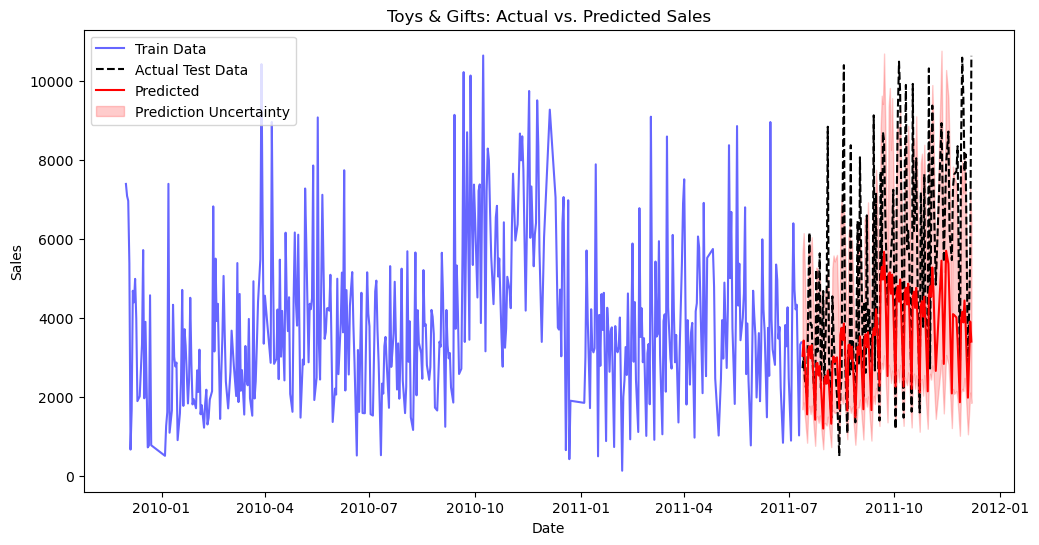

In [ ]:
test_df['ds'] = pd.to_datetime(test_df['ds'])
forecast['ds'] = pd.to_datetime(forecast['ds'])
forecast_test = forecast.set_index('ds').reindex(test_df['ds'])

plt.figure(figsize=(12, 6))
plt.plot(train_df['ds'], train_df['y'], label='Train Data', color='blue', alpha=0.6)
plt.plot(test_df['ds'], test_df['y'], label='Actual Test Data', color='black', linestyle='dashed')
plt.plot(forecast_test.index, forecast_test['yhat'], label='Predicted', color='red')
plt.fill_between(forecast_test.index, forecast_test['yhat_lower'], forecast_test['yhat_upper'],
                 color='red', alpha=0.2, label='Prediction Uncertainty')

plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Toys & Gifts: Actual vs. Predicted Sales')
plt.legend()
plt.show()